# ECMWF Temperature Analysis

In [9]:
import csv
import pandas as pd
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid, cm
from scipy import signal

# You'll need netCDF4 to extract info from the .nc file and use this notebook. 
# Having Anaconda with Python 3 helps a lot as well. Install numpy and matplotlib. 
# Python2 should work, but I, Robert Mao, wrote this in Python3. 

In [10]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [11]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print(("\t\ttype:", repr(nc_fid.variables[key].dtype)))
            for ncattr in nc_fid.variables[key].ncattrs():
                print(('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))))
        except KeyError:
            print(("\t\tWARNING: %s does not contain variable attributes" % key))

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim) 
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [12]:
nc_f = './sdwaccm_tuzgw_2009_01_15_00000.nc'
nc_fid = Dataset(nc_f, mode='r')

nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

NetCDF Global Attributes:
	Conventions: 'CF-1.0'
	history: 'Thu Oct  6 08:30:50 2016: ncks -v t,latitude,longitude,level ecmwf_20121101_00_ori.nc ecmwf_20121101_00_t.nc\n2015-07-09 10:32:45 GMT by grib_to_netcdf-1.12.3: grib_to_netcdf 20121101_00_llpl.grb -R 20121101 -o 20121101_00_llpl.nc'
	NCO: '4.0.3'
NetCDF dimension information:
	Name: latitude
		size: 1201
('\t\ttype:', "dtype('float32')")
('\t\tunits:', "'degrees_north'")
('\t\tlong_name:', "'latitude'")
	Name: level
		size: 25
('\t\ttype:', "dtype('int32')")
('\t\tunits:', "'millibars'")
('\t\tlong_name:', "'pressure_level'")
	Name: longitude
		size: 2400
('\t\ttype:', "dtype('float32')")
('\t\tunits:', "'degrees_east'")
('\t\tlong_name:', "'longitude'")
	Name: time
		size: 1
('\t\ttype:', "dtype('int32')")
('\t\tunits:', "'hours since 2012-11-01 00:00:0.0'")
('\t\tlong_name:', "'time'")
NetCDF variable information:
	Name: t
		dimensions: ('time', 'level', 'latitude', 'longitude')
		size: 72060000
('\t\ttype:', "dtype('int16')"

# Extract Variables

In [13]:
lons = nc_fid.variables['longitude'][:]
levs = nc_fid.variables['level'][:]
lats = nc_fid.variables['latitude'][:]
temp = nc_fid.variables['t'][:]
time = nc_fid.variables['time'][:]

tmax_units = nc_fid.variables['t'].units
time_idx = 0

# Extract temperature data at 10 millibars 
tenMber = temp[0][5]

# Extract temperature data at 40 degrees North latitude
fortyDegNorth = temp[0][5][333]

# Extract temperature data at 10 degree latitude intervals, from -90 to +90 degrees
tenDegIndices = []
tenDegIntervals = []

for i in range(len(lats)):
    num = lats[i]
    floor = float(int(num)) #round num down ex: 91.05 --> 91.0
    if abs(floor - num) <= 0.11 and floor % 10 == 0: 
        tenDegIndices.append(i)
        tenDegIntervals.append(tenMber[i])
        
# "Triple" the longitude and temperature data (append copies at front and back) to avoid edge effects
# When performing FFT. 
tripleLons = np.concatenate([lons, lons[len(lons) - 1] + lons, 2 * lons[len(lons) - 1] + lons])
tripleTenDegIntervals = []
tripleTenMbers = []
for tenDegInterval in tenDegIntervals: 
    triple = np.concatenate([tenDegInterval, tenDegInterval, tenDegInterval])
    tripleTenDegIntervals.append(triple)
for t in tenMber: 
    triple = np.concatenate([t, t, t])
    tripleTenMbers.append(triple)
targetLons = lons[len(lons) - 1] + lons
tripleFortyDegNorth = np.concatenate([fortyDegNorth, fortyDegNorth, fortyDegNorth])

In [14]:
temp[0][5]

masked_array(
  data=[[201.43430991, 201.43430991, 201.43430991, ..., 201.43430991,
         201.43430991, 201.43430991],
        [201.39106414, 201.39106414, 201.39106414, ..., 201.39106414,
         201.39106414, 201.39106414],
        [201.35961266, 201.36157838, 201.36157838, ..., 201.35961266,
         201.35961266, 201.35961266],
        ...,
        [246.47675057, 246.47675057, 246.47675057, ..., 246.47675057,
         246.47675057, 246.47675057],
        [246.45905912, 246.45905912, 246.45905912, ..., 246.45905912,
         246.45905912, 246.45905912],
        [246.48461344, 246.48461344, 246.48461344, ..., 246.48461344,
         246.48461344, 246.48461344]],
  mask=False,
  fill_value=1e+20)

In [14]:
def lats_finder(deg):
    """Return the index corresponding to the latitudes list value closest to DEG,
    a latitude where positive degrees indicate North.
    
    >>>lats_finder(90)
    0
    """
    assert deg <= 90 and deg >= -90, "Not a valid latitude."
    diff, index = 1, 0
    for i in range(len(lats)):
        if abs(lats[i] - deg) < diff:
            diff, index = abs(lats[i] - deg), i
    return index

def lons_finder(deg):
    """Return the index corresponding to the longitudes list value closest to DEG, a longitude."""
    assert deg >= 0 and deg <= 360, "Not a valid longitude."
    diff, index = 1, 0
    for i in range(len(lons)):
        if abs(lons[i] - deg) < diff:
            diff, index = abs(lons[i] - deg), i
    return index


Extract Variables for 60N

In [15]:
# Extract temperature data at 60 degrees North latitude
sixtyDegNorth = temp[0][5][lats_finder(60)]
tripleSixtyDegNorth = np.concatenate([sixtyDegNorth, sixtyDegNorth, sixtyDegNorth])

Plot 60N Latitude Temps

Text(0.5, 1.0, 'Temperature at 60N Latitude (Distance Domain)')

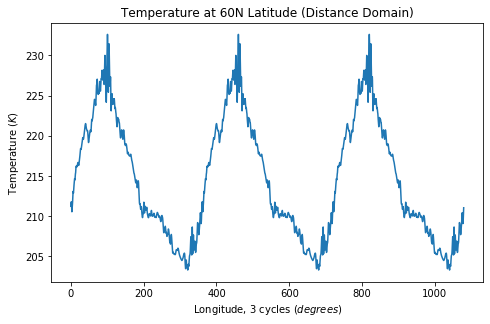

In [21]:
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
plt.plot(tripleLons, tripleSixtyDegNorth)
plt.xlabel('Longitude, 3 cycles ($degrees$)')
plt.ylabel('Temperature ($K$)')
plt.title('Temperature at 60N Latitude (Distance Domain)')

Text(0.5, 1.0, 'Temperature at 60N Latitude (Distance Domain)')

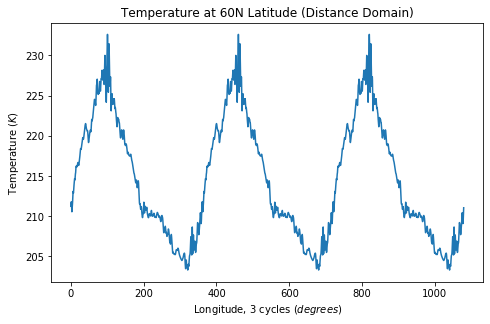

In [39]:
#Alternative method to finding temperature data for multiple 10 degrees
#Uses the tenDegIntervals list made by Robert; comes with a bit of inconvenience
altSixty = tenDegIntervals[3]
altTripleSixty = np.concatenate([altSixty, altSixty, altSixty])
#Plotting gives the same graph
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
plt.plot(tripleLons, altTripleSixty)
plt.xlabel('Longitude, 3 cycles ($degrees$)')
plt.ylabel('Temperature ($K$)')
plt.title('Temperature at 60N Latitude (Distance Domain)')

# Plot 40N Latitude Temps in Distance, Frequency, Periodic Domain

Text(0.5, 1.0, 'Temperature at 40N Latitude (Distance Domain)')

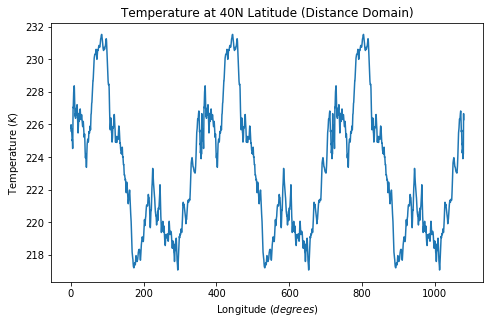

In [21]:
# Plot the longitude and temperature data
# In Time Domain
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
plt.plot(tripleLons, tripleFortyDegNorth)
plt.xlabel('Longitude ($degrees$)')
plt.ylabel('Temperature ($K$)')
plt.title('Temperature at 40N Latitude (Distance Domain)')

In [22]:
# Find sample time and frequency

dt = tripleLons[1] - tripleLons[0]
fa = 1.0/dt # scan frequency
N = len(tripleLons)//2 + 1
print('dt=%.5fdeg (Sample Time)' % dt)
print('fa=%.2fHz (Frequency)' % fa)


dt=0.15000deg (Sample Time)
fa=6.67Hz (Frequency)


In [23]:
# Create hanning window function 
# Generate linear space for longitude values 
# Run FFT and apply hanning function 
# Normalize to get real physical information 

hann = np.hanning(len(tripleLons))
X = np.linspace(0, fa/2, N, endpoint=True)
Y = np.fft.fft(hann * tripleFortyDegNorth)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


[0.         0.00092593 0.00185185 0.00277778 0.0037037  0.00462963
 0.00555556 0.00648148 0.00740741 0.00833333]
[446.27332342 223.18299985   2.42832719   4.87682434   2.4354429
   0.66195598   1.31779329   0.66095707   0.87937091   1.76030993]


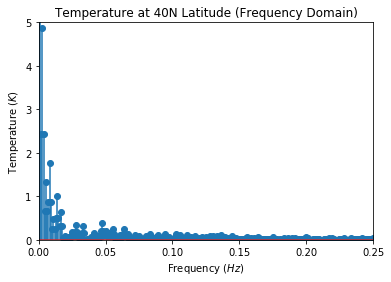

In [24]:
# Plot the longitude and temperature data
# In Frequency Domain

plt.stem(X , 2.0 / N *np.abs(Y[:N]))
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Temperature ($K$)')
plt.title('Temperature at 40N Latitude (Frequency Domain)')
plt.axis([0,0.25,0,5])

print (X[:10])
print ((2.0 / N *np.abs(Y[:N])[:10]))

In [25]:
# Convert to period: reciprocal of sampling rate. 

Xp = 1.0/X # in degrees 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


([<matplotlib.axis.XTick at 0x1a36ead210>,
 <a list of 14 Text xticklabel objects>)

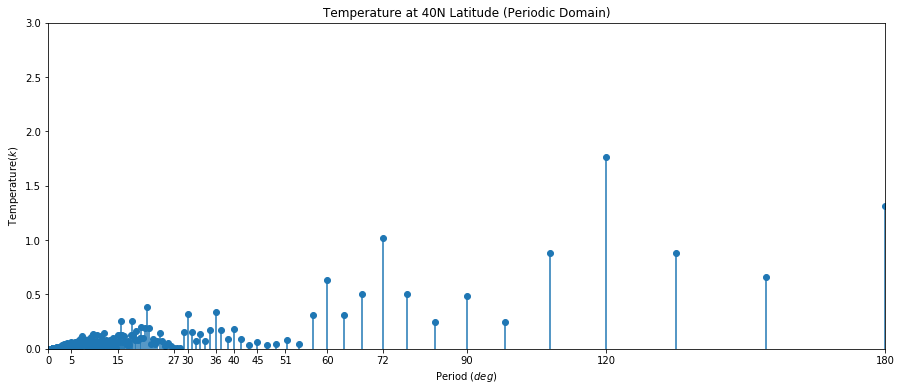

In [26]:
# Plot the period based graph. 
# Largest value, for 360 degrees, is "baseline" temperature for latitude, based on my guess. 
# Looks like more interesting, smaller scale, waves come from 180 degrees and less.  

plt.figure(1, figsize=(15,6))
plt.stem(Xp, (2.0*np.abs(Y[:N])/N))
plt.xlim(0, 180)
plt.ylim(0, 3)
plt.xlabel('Period ($deg$)')
plt.ylabel('Temperature($k$)')
plt.title('Temperature at 40N Latitude (Periodic Domain)')
plt.xticks([0, 5, 15, 27, 30, 36, 40, 45, 51, 60, 72, 90, 120, 180])

# plt.savefig('Temperature40DegreesLatitude2012-FFT.png',bbox_inches='tight', dpi=150, transparent=True)

# Plot Temperature for distance, frequency, and periodic domain -90 to +90 at 10 deg lat intervals

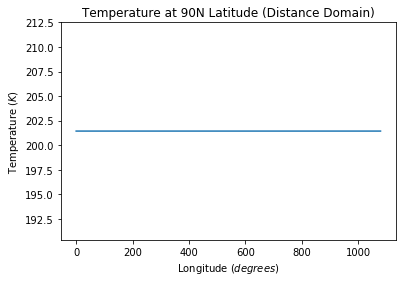

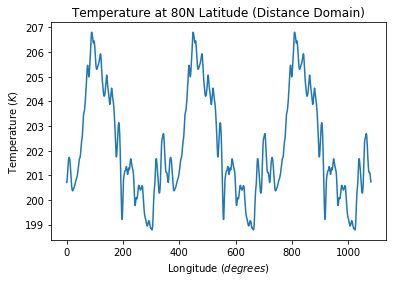

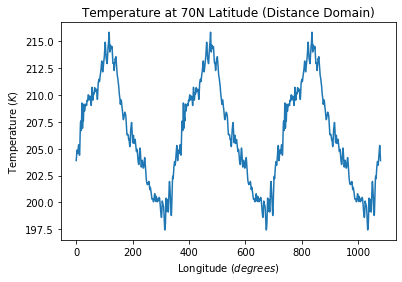

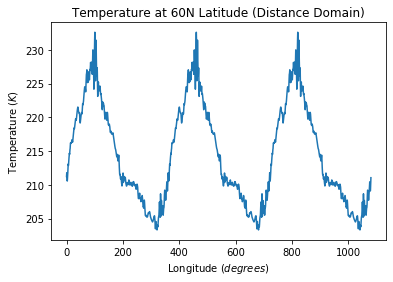

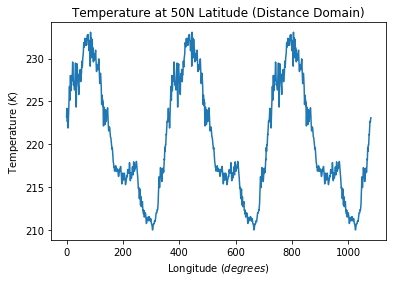

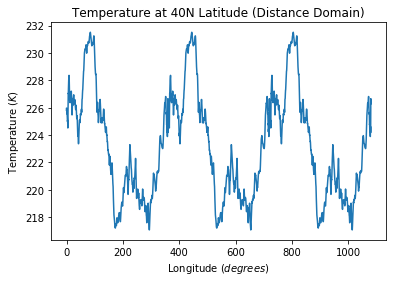

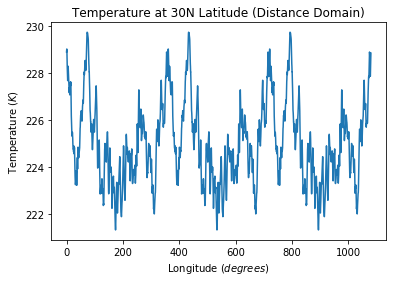

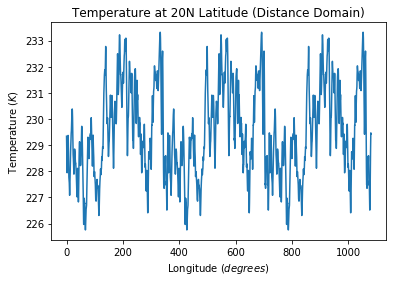

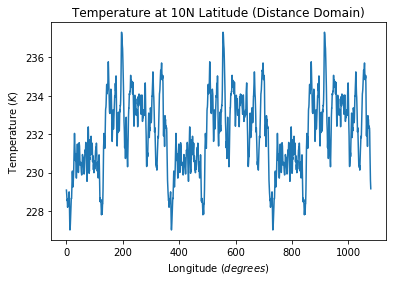

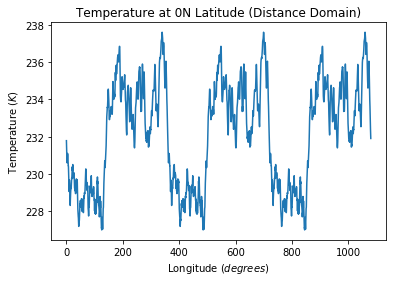

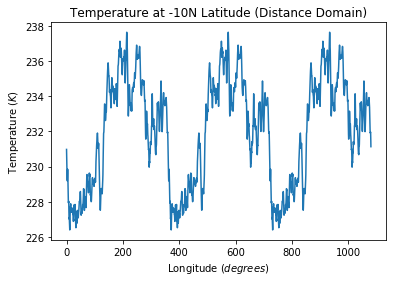

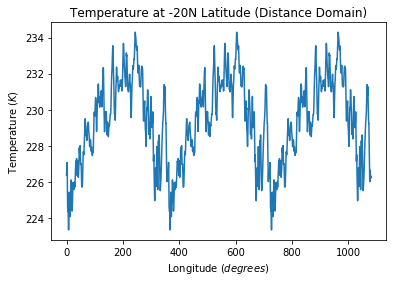

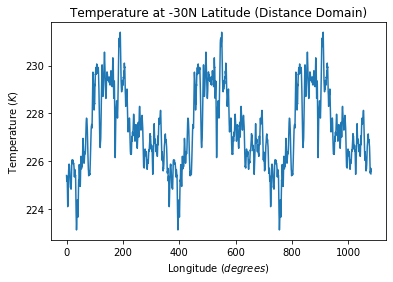

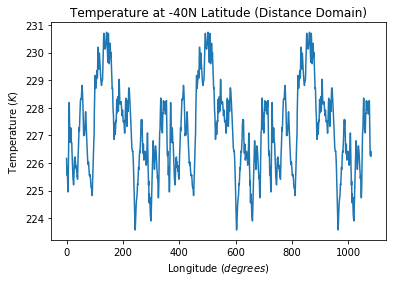

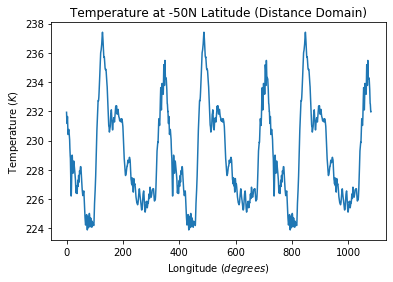

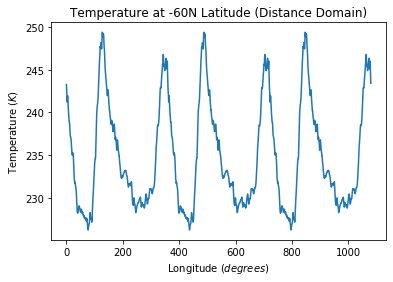

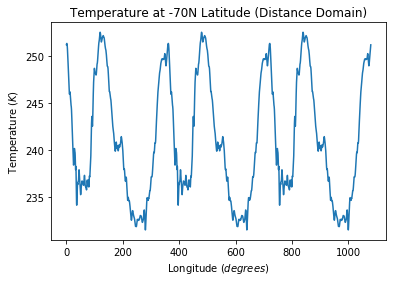

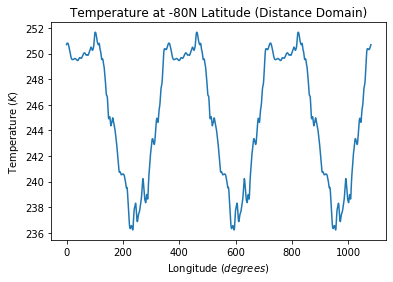

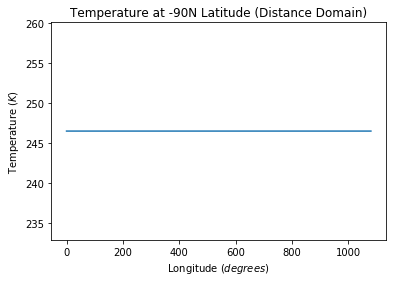

In [27]:
# Systematically repeat process for 40 deg latitude at all latitudes. 

# Again, plot Temperature versus Longitude for everything. 

for i in range(len(tripleTenDegIntervals)): 
    plt.plot(tripleLons, tripleTenDegIntervals[i])
    plt.xlabel('Longitude ($degrees$)')
    plt.ylabel('Temperature ($K$)')
    plt.title('Temperature at %iN Latitude (Distance Domain)' % int(lats[tenDegIndices[i]]))
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


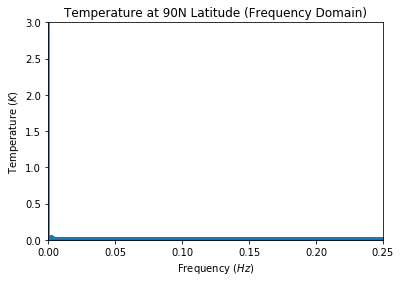

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


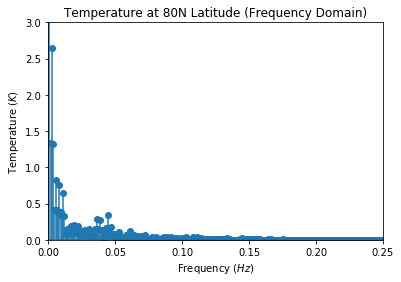

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


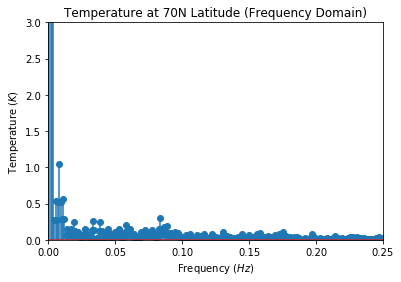

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


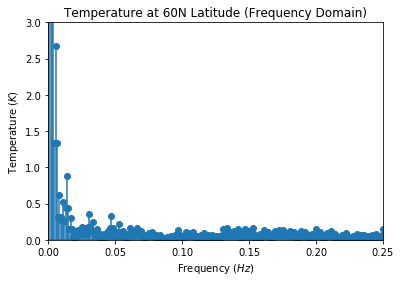

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


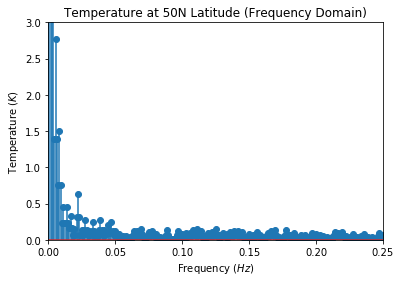

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


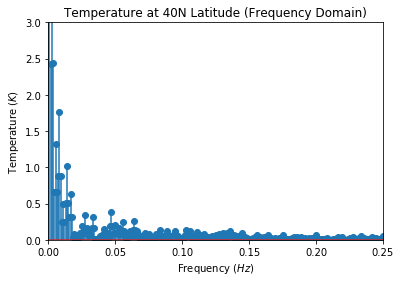

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


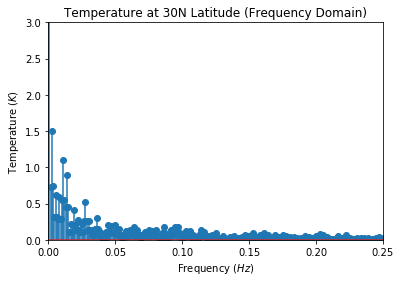

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


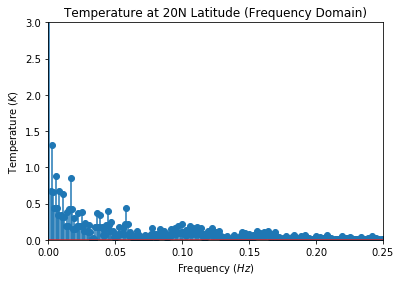

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


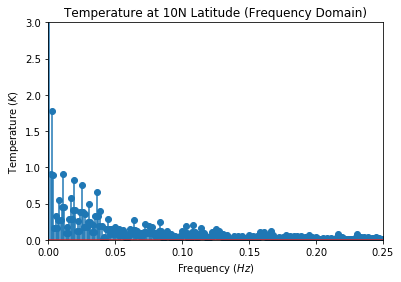

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


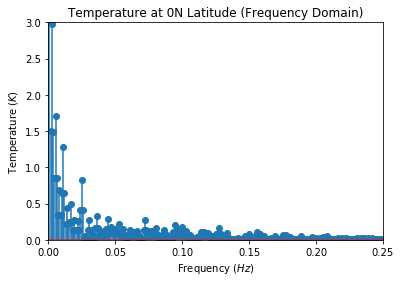

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


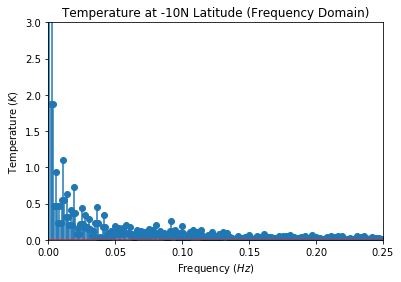

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


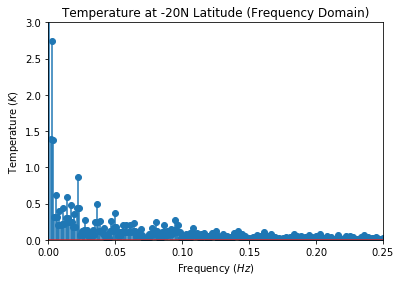

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


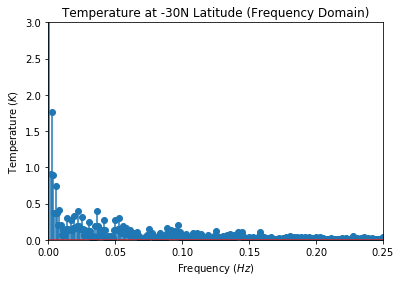

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


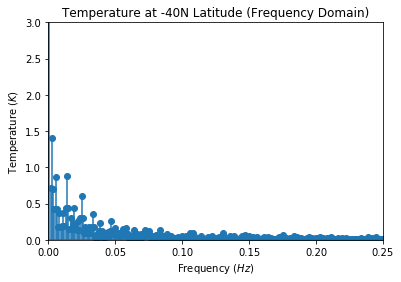

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


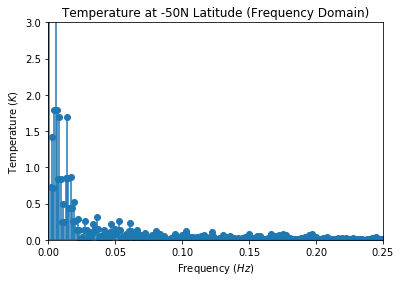

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


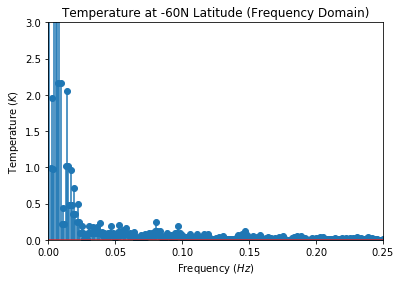

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


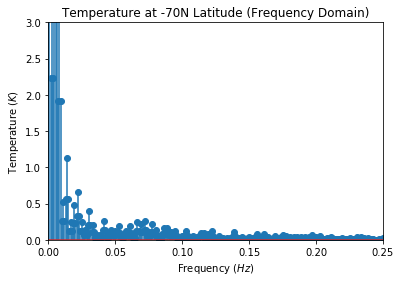

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


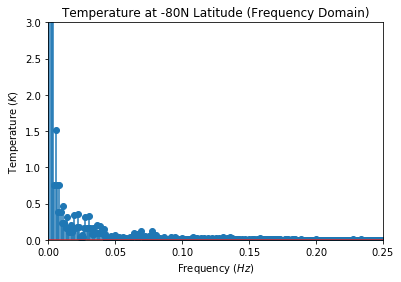

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


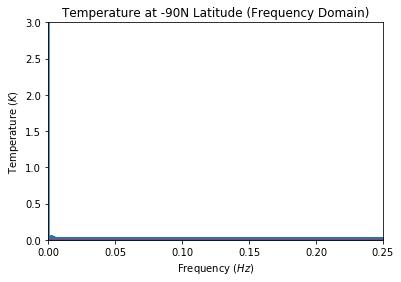

In [28]:
# Find sample time and frequency
# Create hanning function 
# Apply hanning function
# Run FFT
# Plot data

for i in range(len(tripleTenDegIntervals)):
    data = tripleTenDegIntervals[i]
    
    dt = tripleLons[1] - tripleLons[0]
    fa = 1.0/dt # scan frequency
    N = len(data)//2 + 1
    
    hann = np.hanning(len(tripleLons))
    X = np.linspace(0, fa/2, N, endpoint=True)
    Y = np.fft.fft(hann * data)
    
    plt.stem(X , 2.0 / N *np.abs(Y[:N]))
    plt.xlabel('Frequency ($Hz$)')
    plt.ylabel('Temperature ($K$)')
    plt.title('Temperature at %iN Latitude (Frequency Domain)' % int(lats[tenDegIndices[i]]))
    plt.axis([0,0.25,0,3])
    
    plt.show()
    
    



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


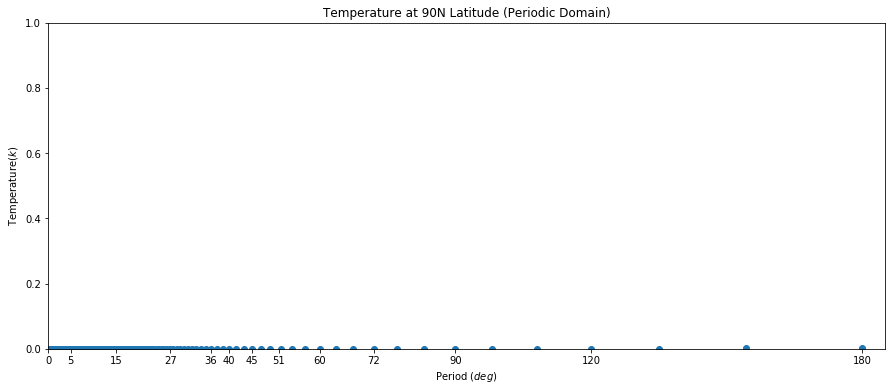

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


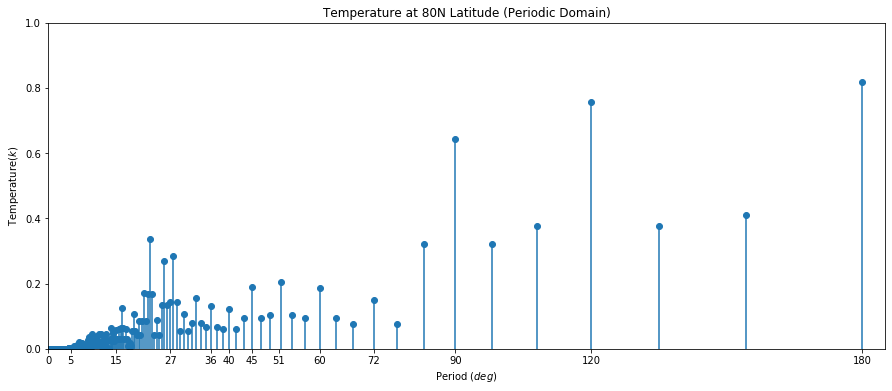

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


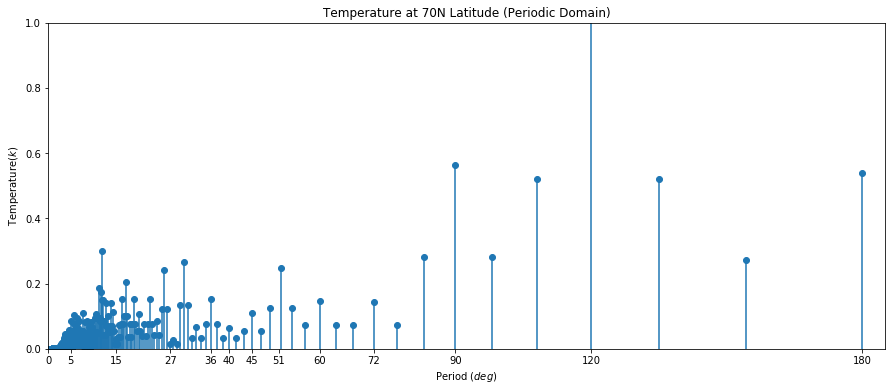

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


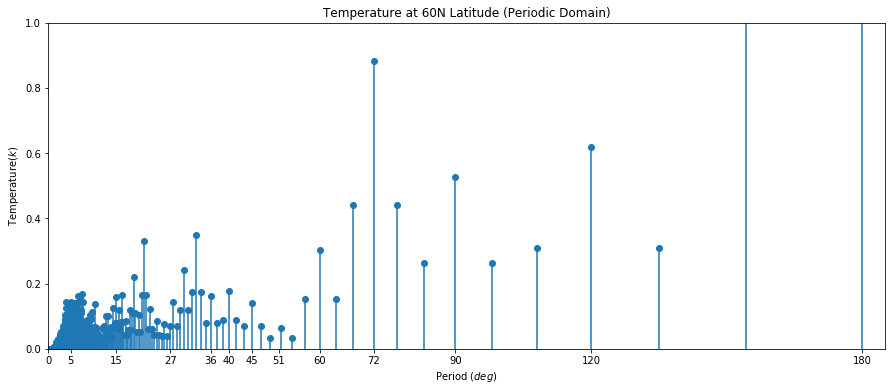

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


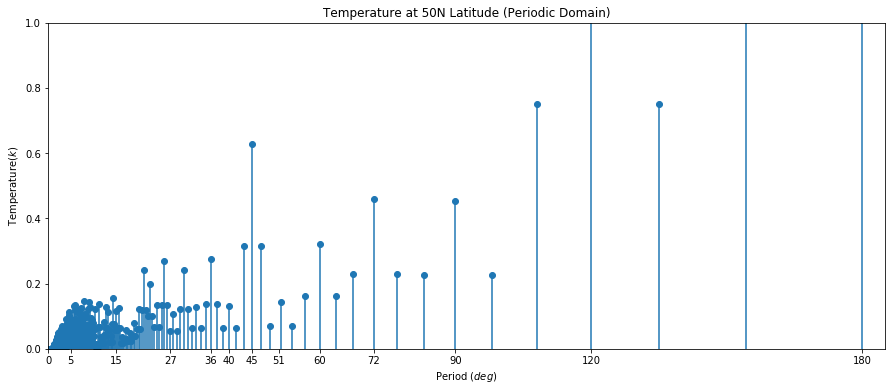

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


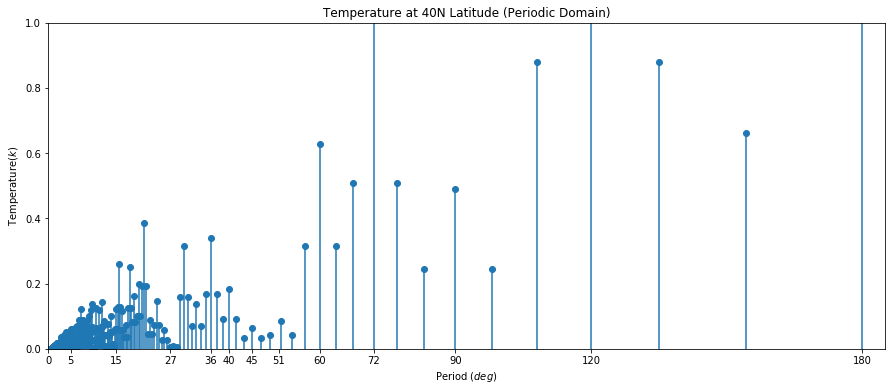

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


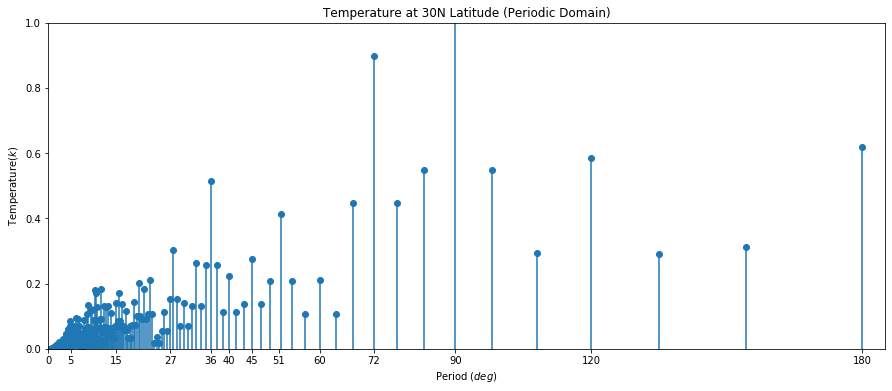

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


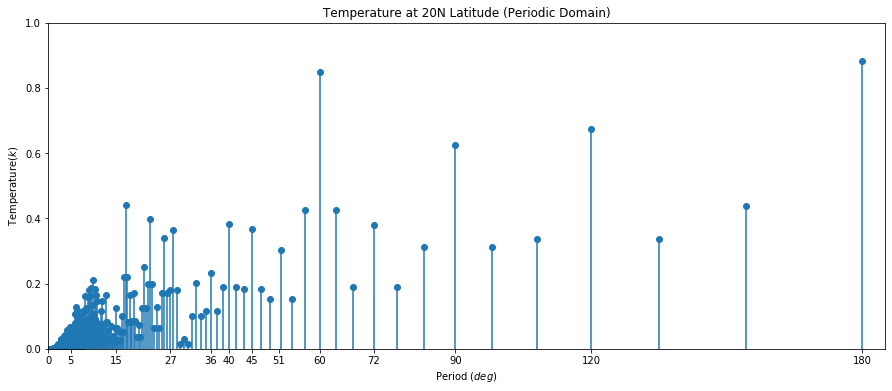

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


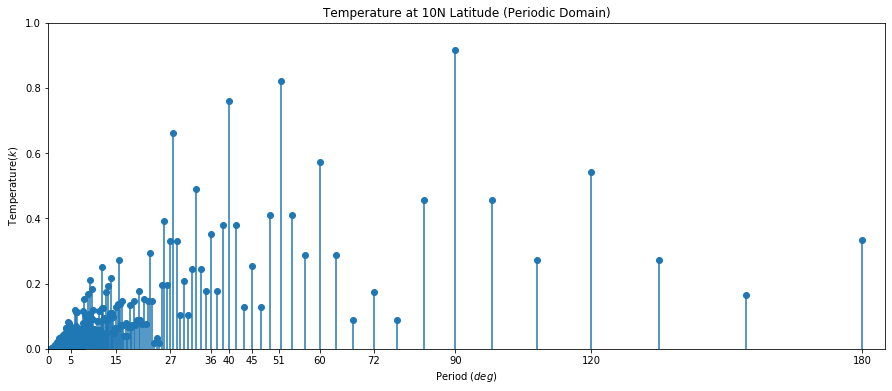

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


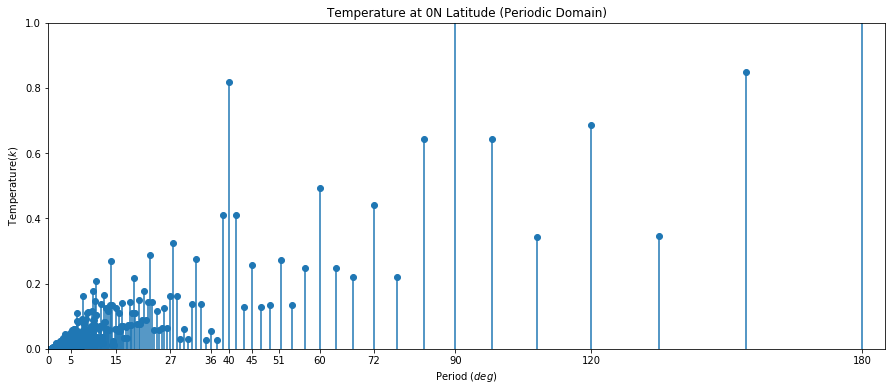

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


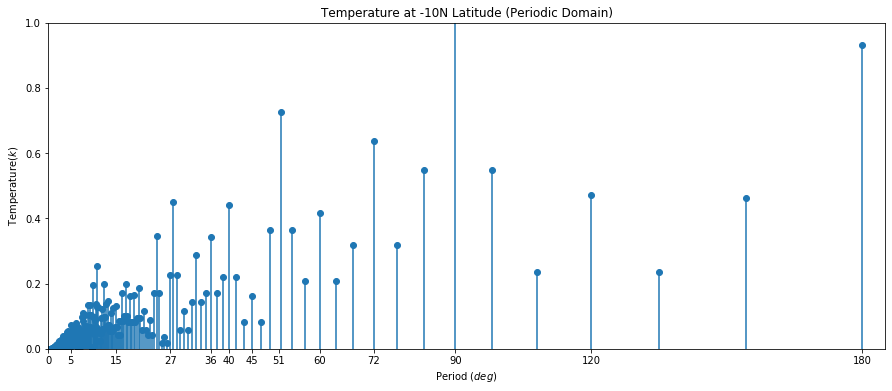

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


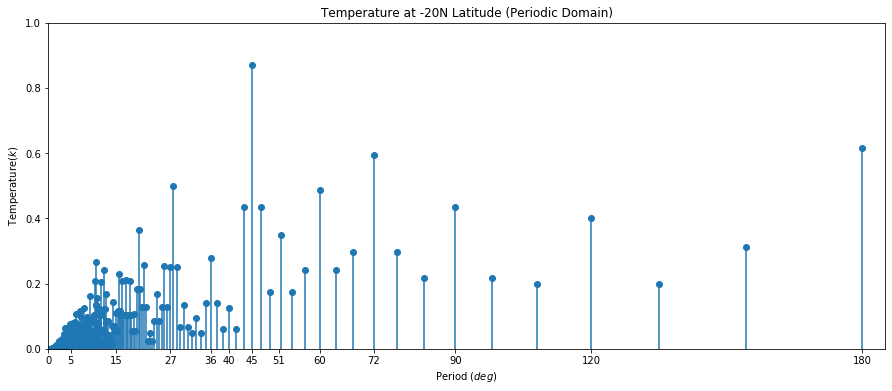

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


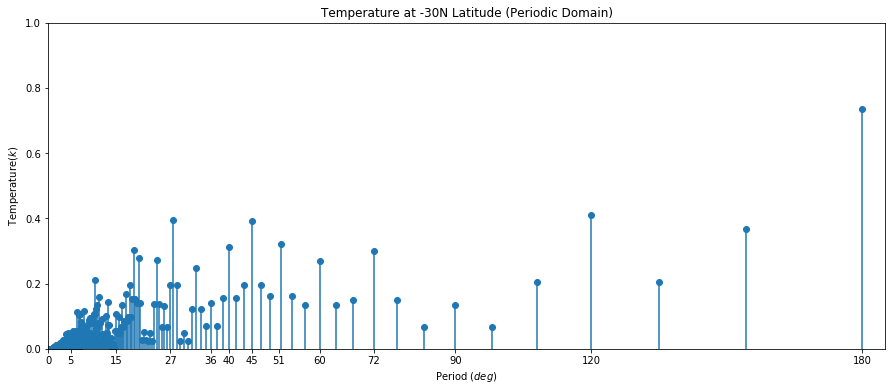

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


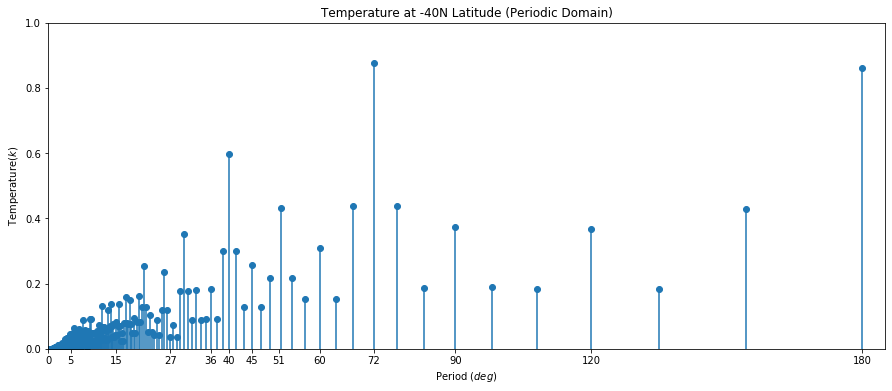

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


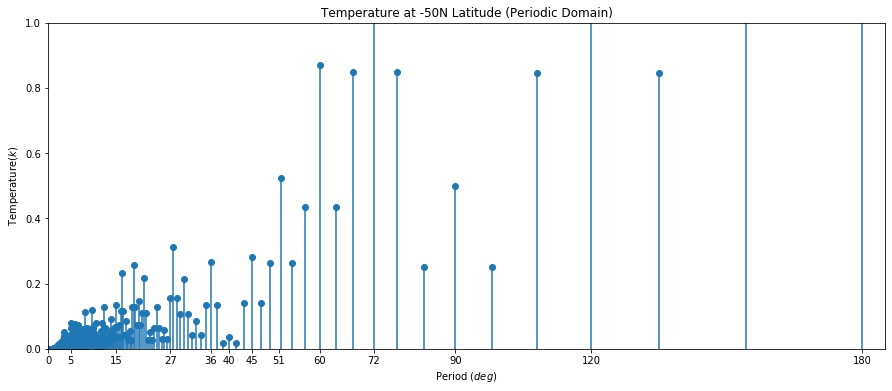

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


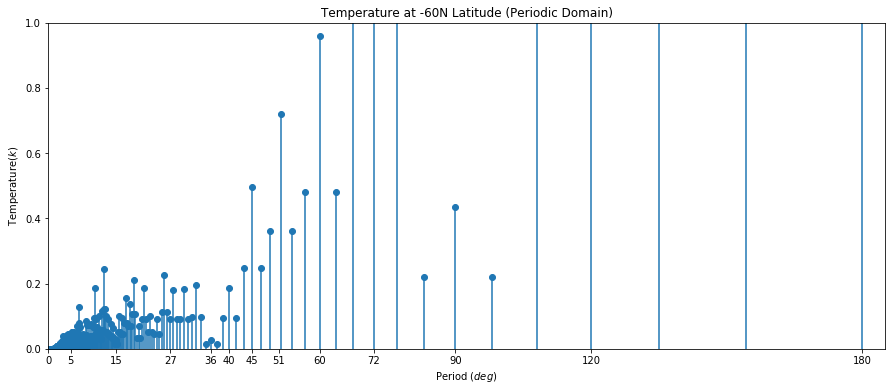

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


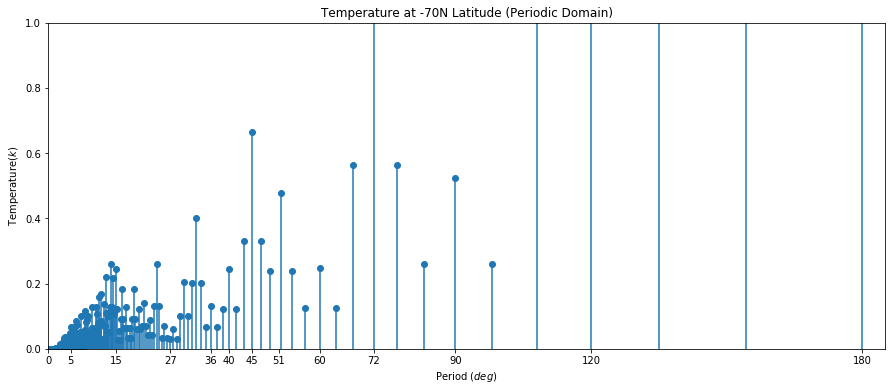

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


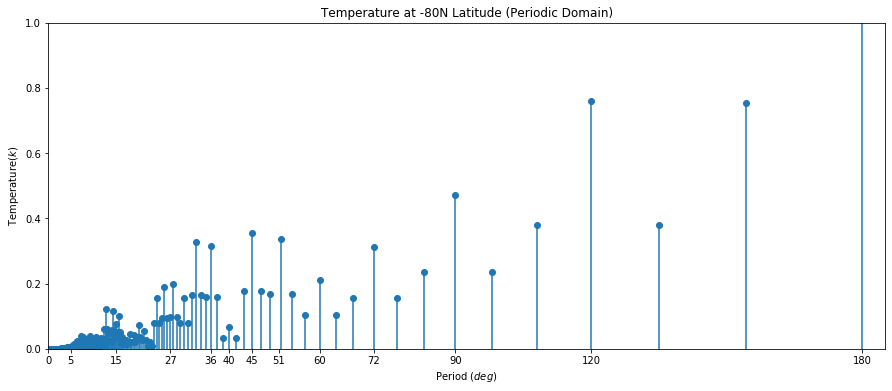

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


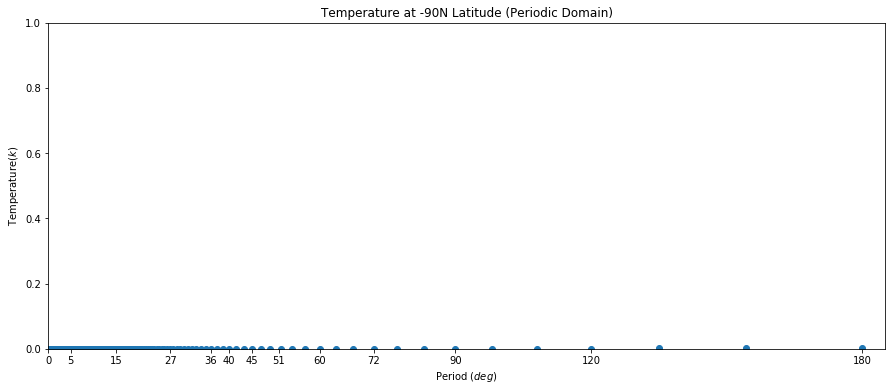

In [29]:
# Plot the period based graph. 
# Largest value, for 360 degrees, is "baseline" temperature for latitude, based on my guess. 
# Looks like more interesting, smaller scale, waves come from 180 degrees and less.  

for i in range(len(tripleTenDegIntervals)):
    data = tripleTenDegIntervals[i]
    
    dt = tripleLons[1] - tripleLons[0]
    fa = 1.0/dt # scan frequency
    N = len(data)//2 + 1
    
    hann = np.hanning(len(tripleLons))
    X = np.linspace(0, fa/2, N, endpoint=True)
    Y = np.fft.fft(hann * data)
    
    Xp = 1.0/X 
    
    plt.figure(1, figsize=(15,6))
    plt.stem(Xp, (2.0*np.abs(Y[:N])/N))
    plt.xlim(0, 185)
    plt.ylim(0, 1)
    plt.xlabel('Period ($deg$)')
    plt.ylabel('Temperature($k$)')
    plt.title('Temperature at %iN Latitude (Periodic Domain)' % int(lats[tenDegIndices[i]]))
    plt.xticks([0, 5, 15, 27, 36, 40, 45, 51, 60, 72, 90, 120, 180])
    
    # plt.savefig('Temperature%iDegreesLatitude2012-FFT.png' % int(lats[tenDegIndices[i]]),bbox_inches='tight', dpi=150, transparent=True)
    
    plt.show()

# Helper Functions for Butterworth Filters 

In [30]:
# Helper Functions for high-pass (Butterworth) filter. 
# http://stackoverflow.com/questions/39032325/python-high-pass-filter

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Helper Functions for band-pass (Butterworth) filter.
# http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq 
    high = highcut / nyq 
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

## Sliding Window Helper Function ## 

In [31]:
def window_rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

# Inverse FFT to extract time domain information  

In [32]:
# Run np.fft.ifft and plot against longitude, in kilometers. 

def filter_select(lowRange, highRange, data, longToKm, fa, sliding_window, window_size):
    if lowRange and highRange == 0: 
        return 
    elif lowRange == 0: 
        cutoff = longToKm / highRange # Cut off all waves with wavelength > highRange KM
        filtered_signal  = butter_highpass_filter(data,cutoff,fa, order=3)
    else: 
        highcut = longToKm / lowRange # Cut off all waves with wavelength < lowRange KM
        lowcut = longToKm / highRange # Cut off all waves with wavelength > highRange KM
        filtered_signal = butter_bandpass_filter(data, lowcut, highcut, fa, order = 3)
    if sliding_window: 
        filtered_signal = window_rms(filtered_signal, window_size)   
    return filtered_signal

def inverse_filter(lowRange, highRange, sliding_window=False, window_size=300):
    for i in range(len(tenDegIntervals)):
        data = tripleTenDegIntervals[i]

        lat = float(lats[tenDegIndices[i]])
        longToKm = np.cos(np.deg2rad(lat)) * 111.321 # Degree of longitude varies in length w/ latitude 
        X = tripleLons * longToKm # Convert over to longitude 

        dt = tripleLons[1] - tripleLons[0]
        fa = 1.0/dt # scan frequency
        
        filtered_signal = filter_select(lowRange, highRange, data, longToKm, fa, sliding_window, window_size)

        plt.figure(i, figsize=(15,6))
        plt.plot(X[0 : len(lons)], filtered_signal[len(lons) : 2 * len(lons)])

        plt.xlabel('Longitude ($km$)')
        plt.ylabel('Temperature($k$)')
        plt.title('Temperature at %iN Latitude (Periodic Domain) With Wavelength > %i KM and < %i KM' % (int(lats[tenDegIndices[i]]), lowRange, highRange))

        # plt.savefig('Temperature%iDegreesLatitude2012-FFT-Filtered1500KMWavelength.png' % int(lats[tenDegIndices[i]]),bbox_inches='tight', dpi=150, transparent=True)

        plt.show()

def plot_filter(lowRange, highRange, sliding_window=True, window_size=300):
    filtered_data = []
    for i in range(len(tenMber)):
        data = tripleTenMbers[i]
    
        lat = float(lats[i])
        longToKm = np.cos(np.deg2rad(lat)) * 111.321 # Degree of longitude varies in length w/ latitude 
        X = tripleLons * longToKm # Convert over to longitude 

        dt = tripleLons[1] - tripleLons[0]
        fa = 1.0/dt # scan frequency
        
        filtered_signal = filter_select(lowRange, highRange, data, longToKm, fa, sliding_window, window_size)
        # Filter out noisy data at North and South poles
        if max(filtered_signal) > 2.0:
            filtered_data.append([np.zeros(len(lons))])
        else: 
            filtered_data.append([filtered_signal[len(lons) : 2 * len(lons)]])
        
    filtered_data = np.concatenate(filtered_data)
    
    fig = plt.figure()
    fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
    # Setup the map. See http://matplotlib.org/basemap/users/mapsetup.html
    # for other projections.
    m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
                llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
    m.drawcoastlines()
    m.drawmapboundary()
    
    # Make the plot continuous
    air_cyclic, lons_cyclic = addcyclic(filtered_data[:, :], lons)
    # Shift the grid so lons go from -180 to 180 instead of 0 to 360.
    air_cyclic, lons_cyclic = shiftgrid(180., air_cyclic, lons_cyclic, start=False)
    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d)
    
    cs = m.contourf(x, y, air_cyclic, 25, cmap=plt.cm.Spectral_r, vmin=0, vmax=1)
    plt.clim(0,1)
    plt.colorbar()
   
    plt.title("%s on %s" % (nc_fid.variables['t'].long_name, "2012-11-01 00:00:0.0"))
    
    
        

# Sub - 500km wavelength waves

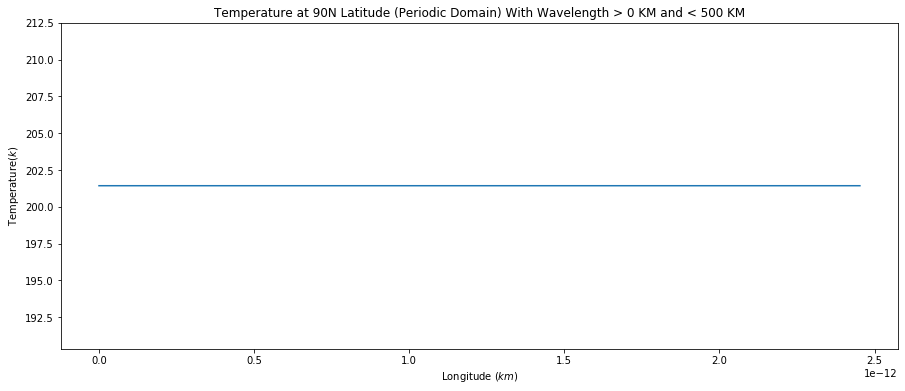

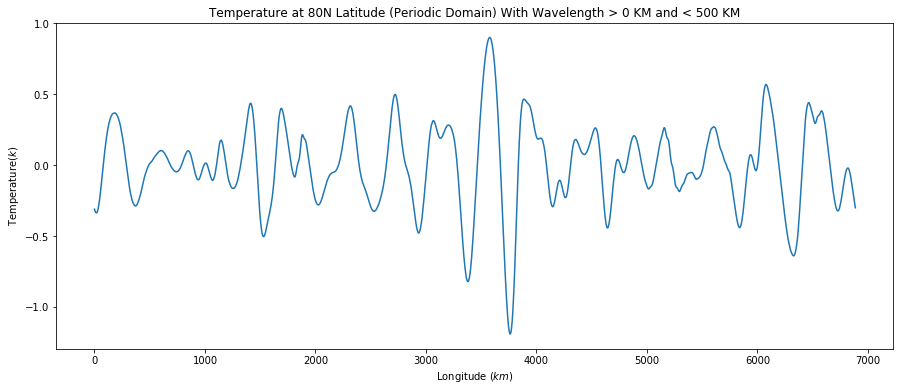

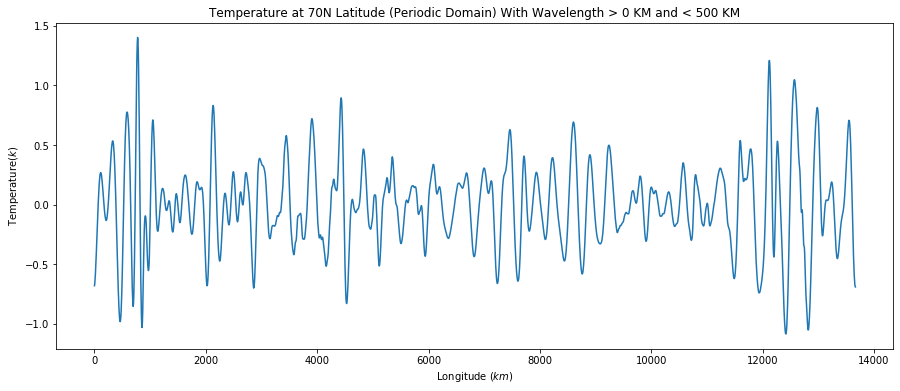

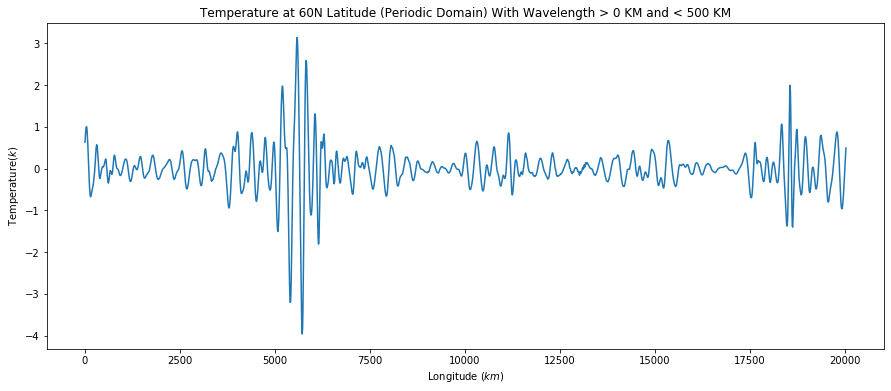

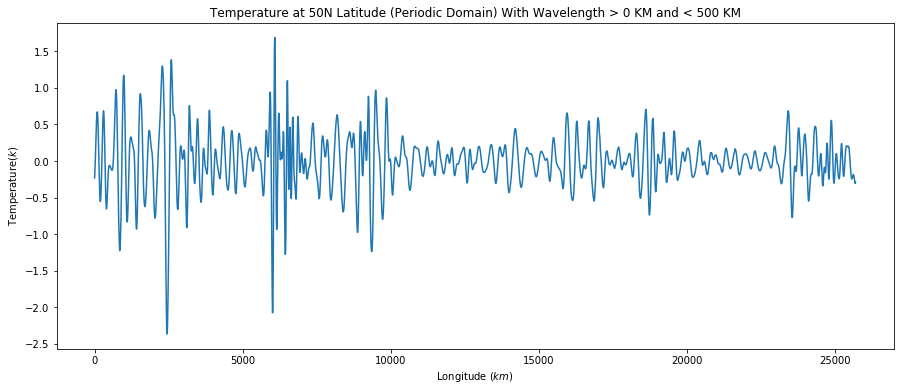

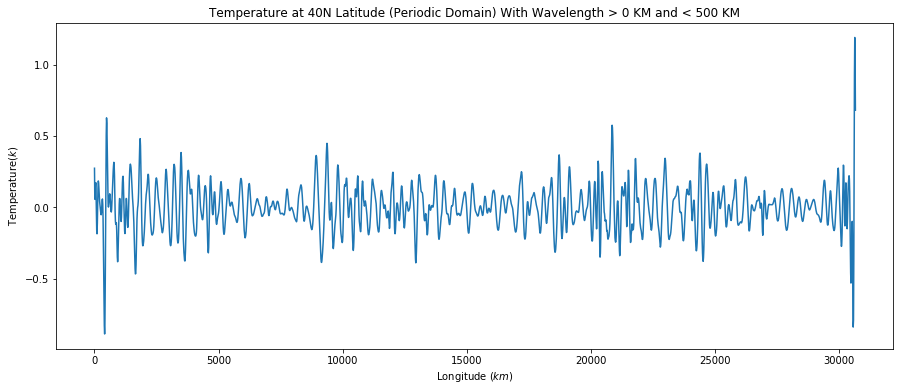

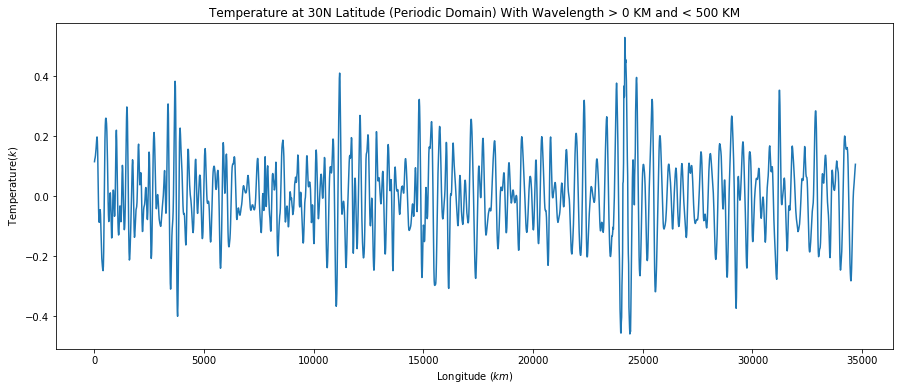

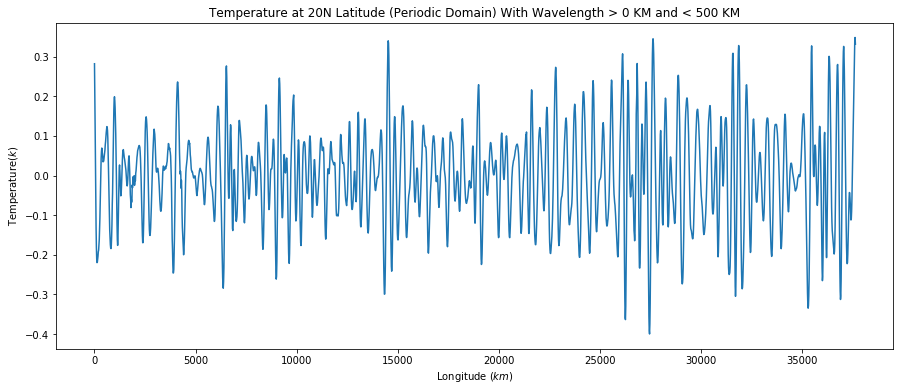

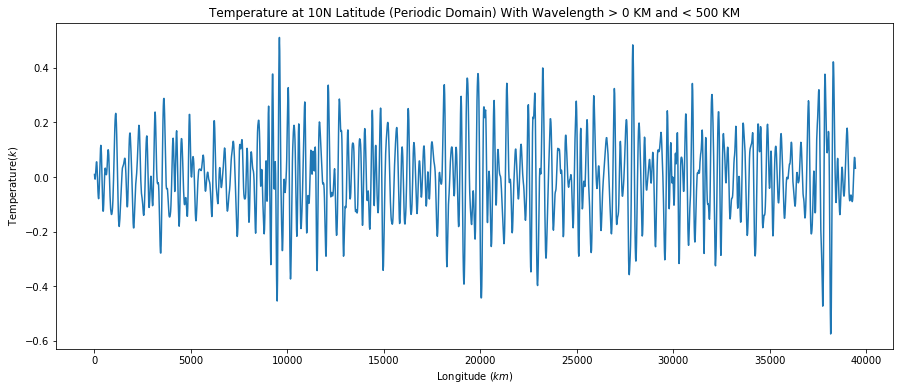

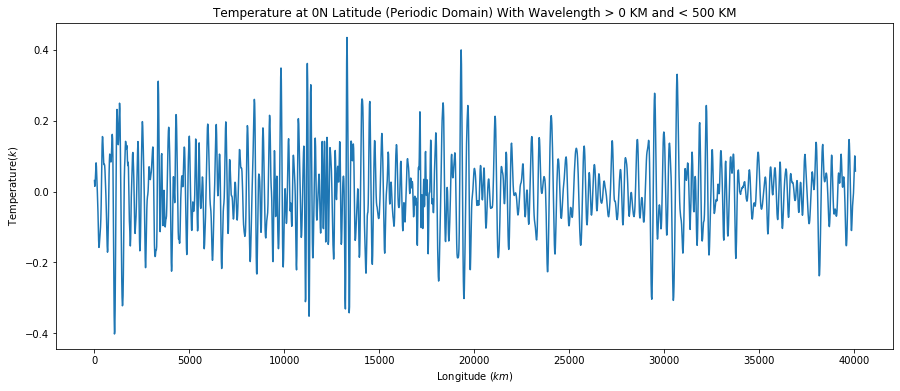

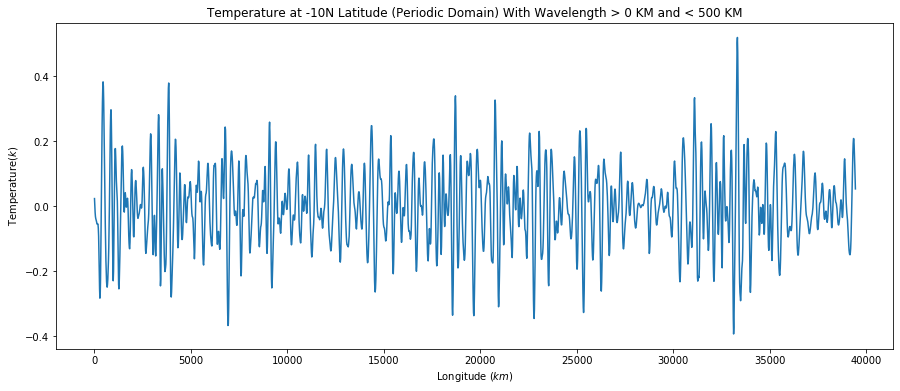

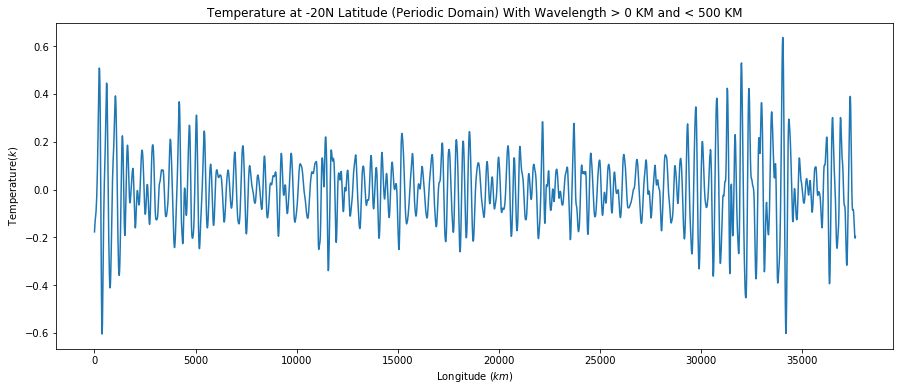

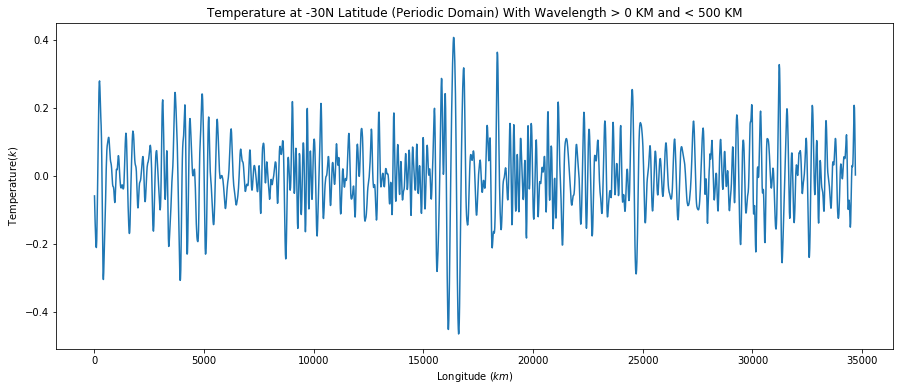

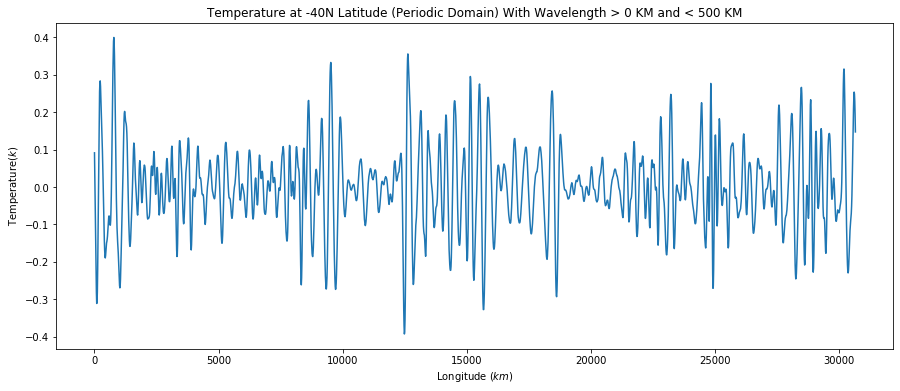

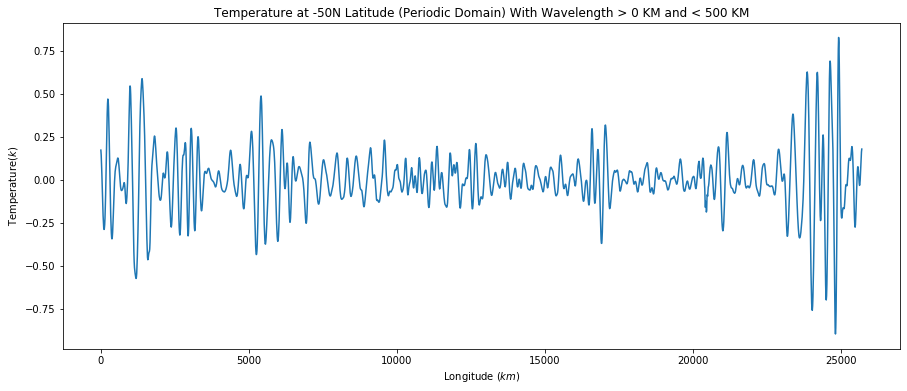

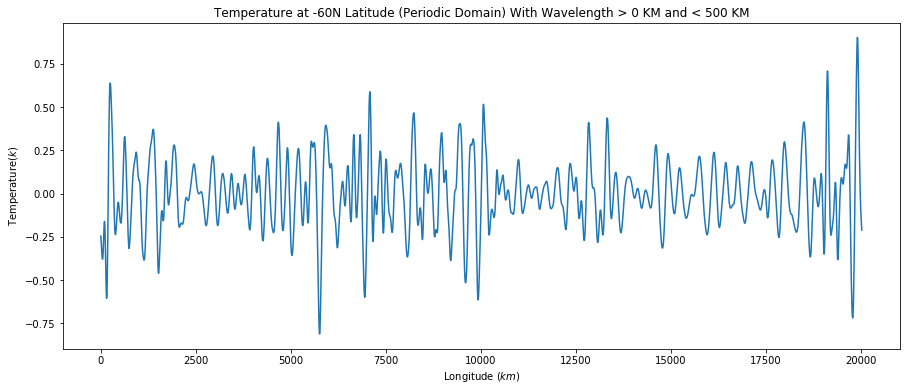

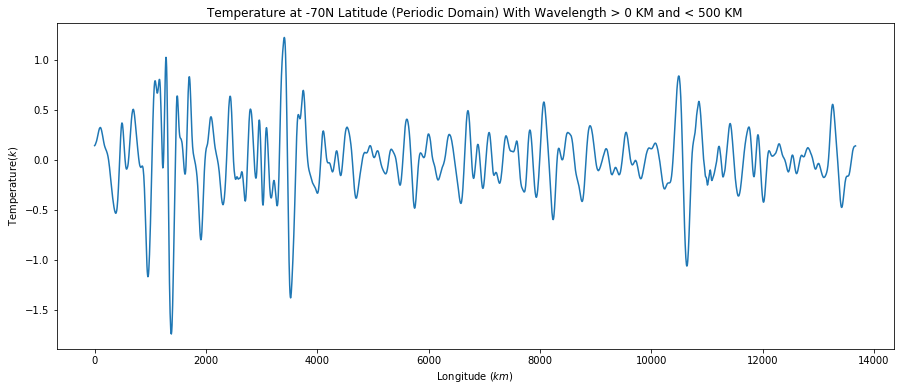

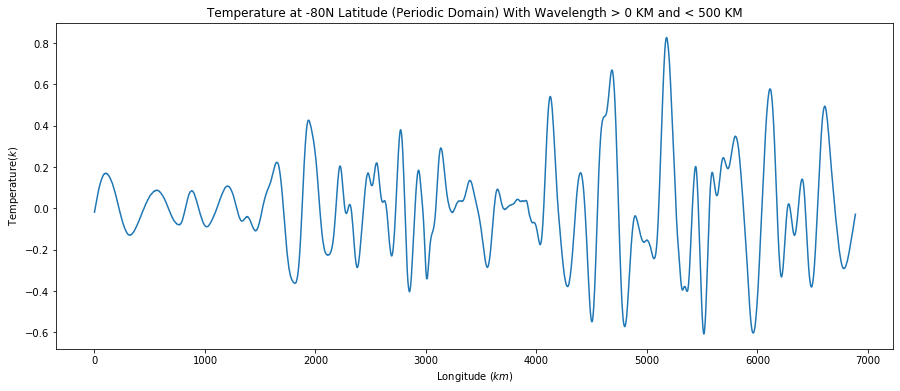

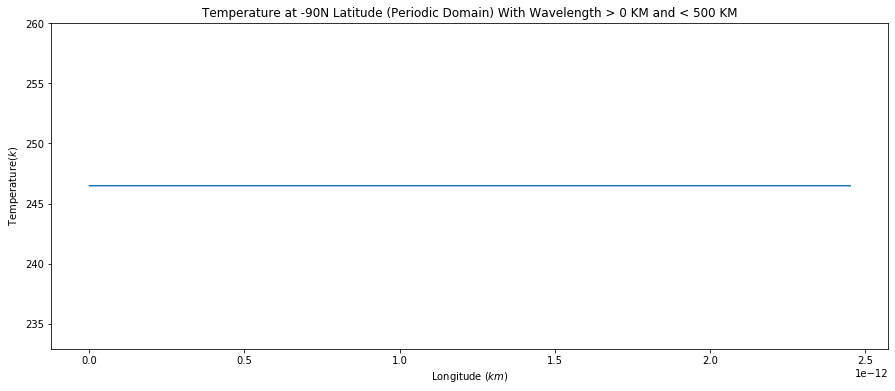

In [33]:
# Run np.fft.ifft and plot against longitude, in kilometers. 

inverse_filter(0, 500)

# 500 KM to 1000 KM Wavelength Waves 

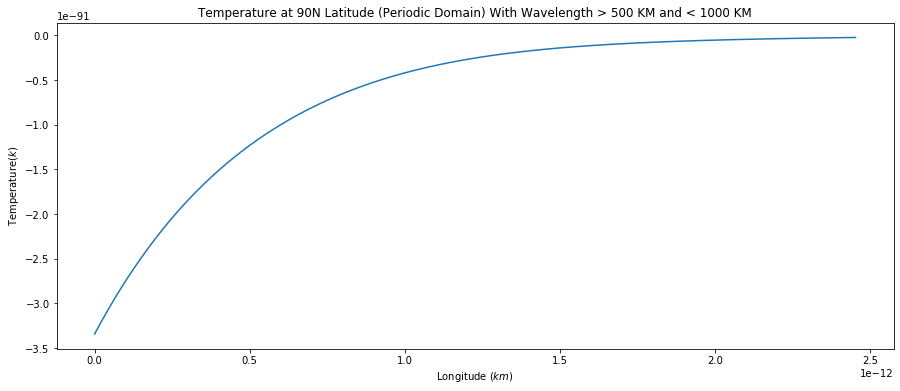

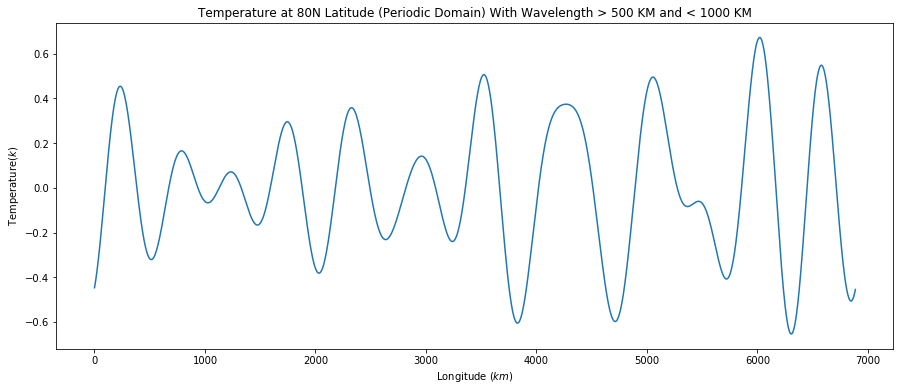

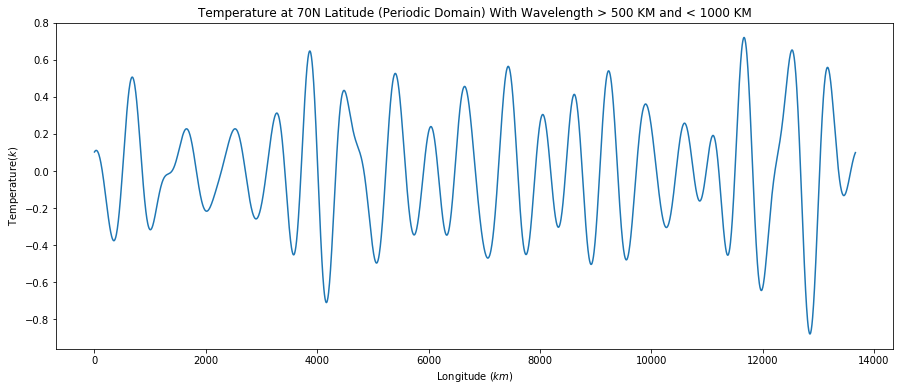

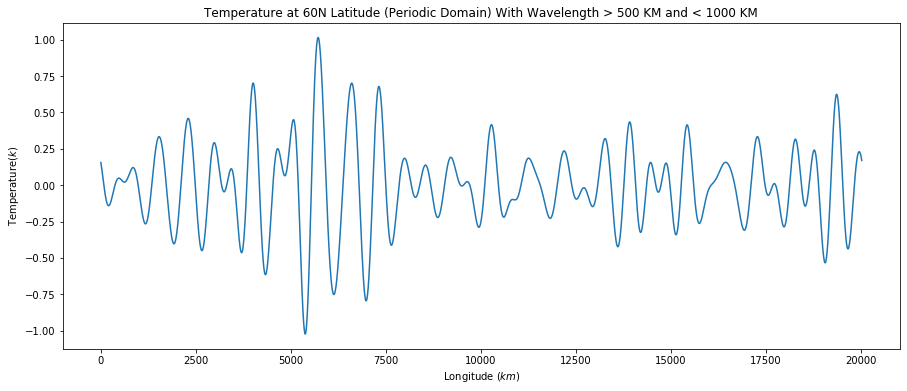

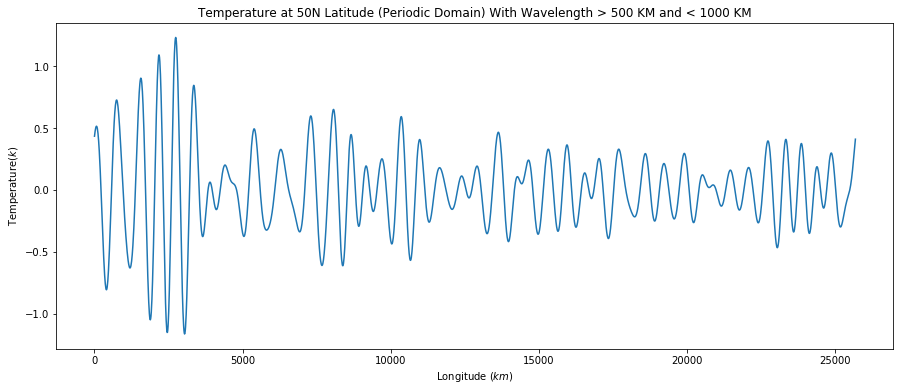

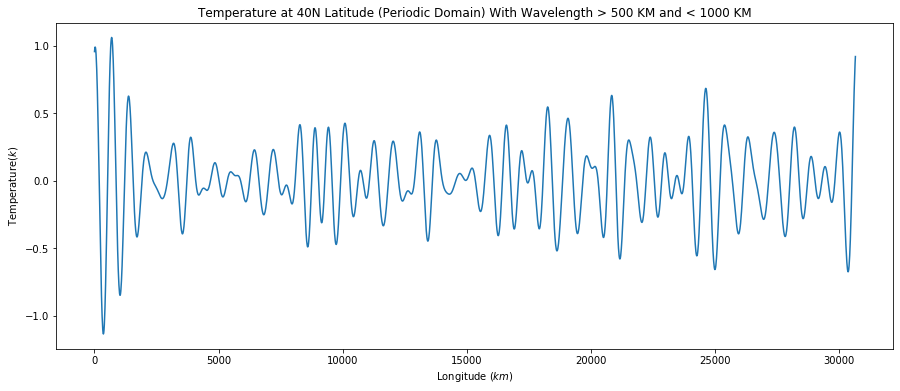

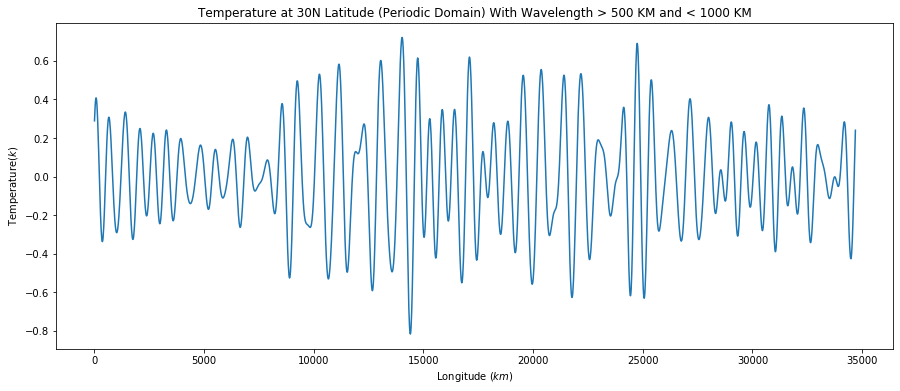

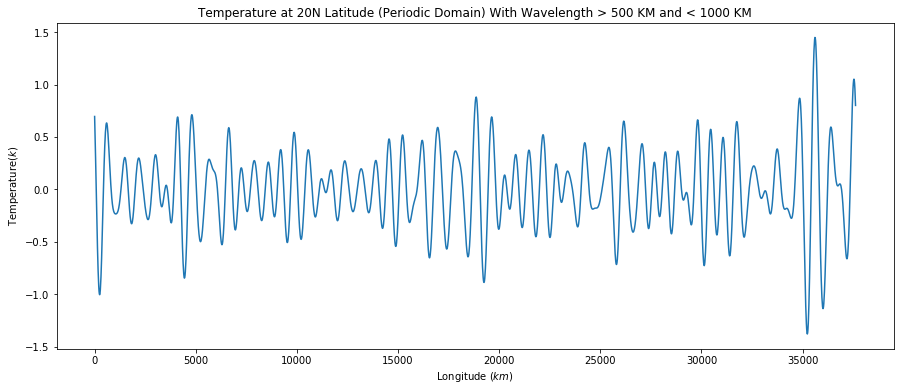

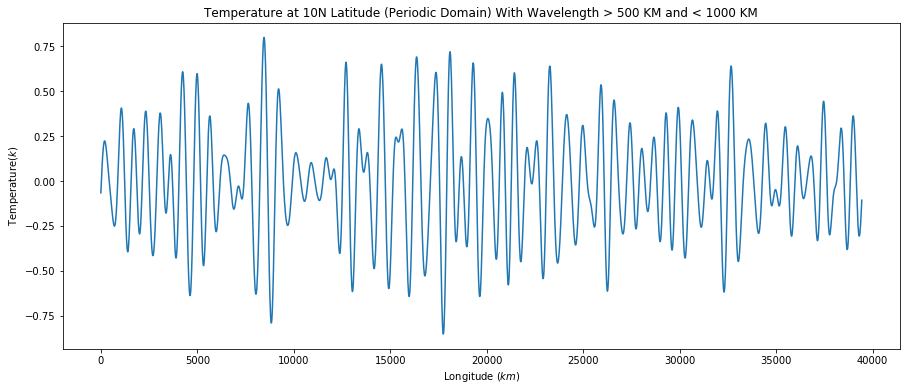

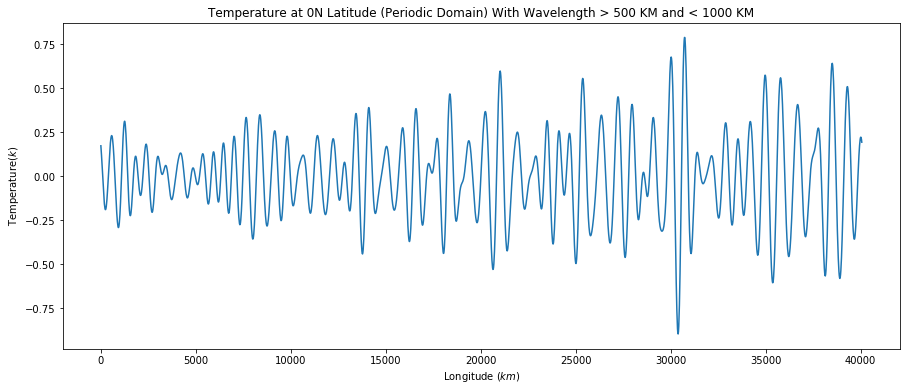

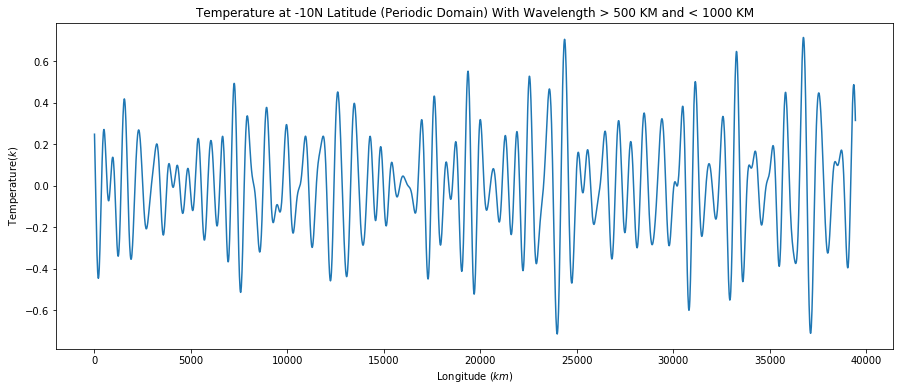

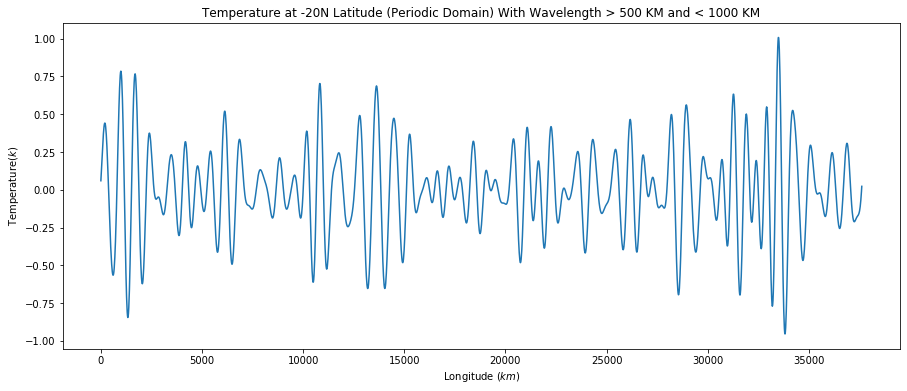

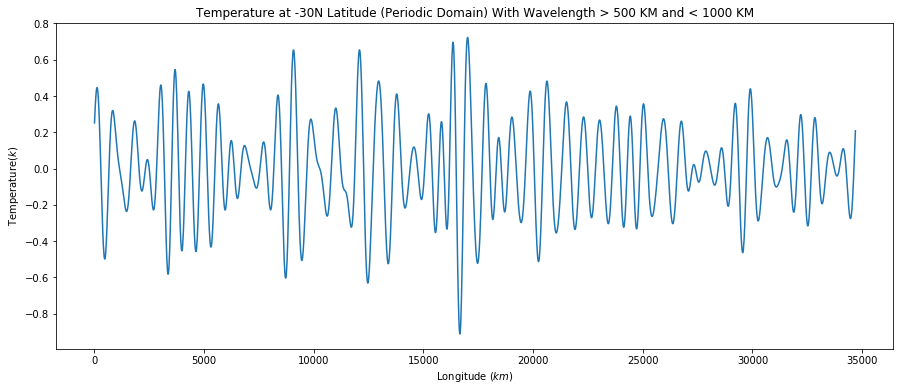

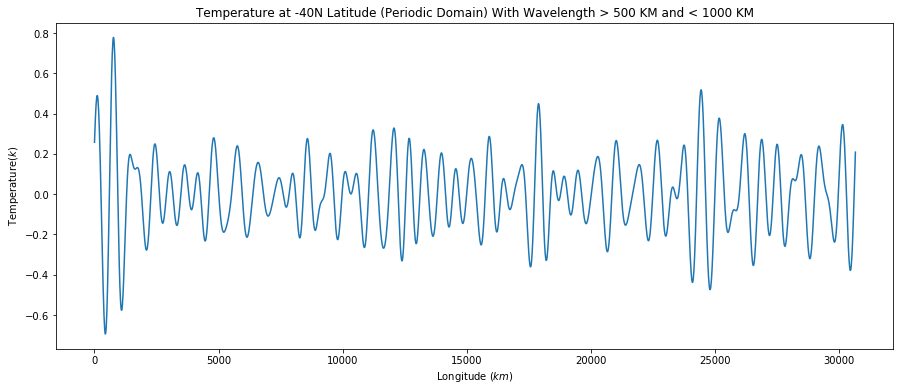

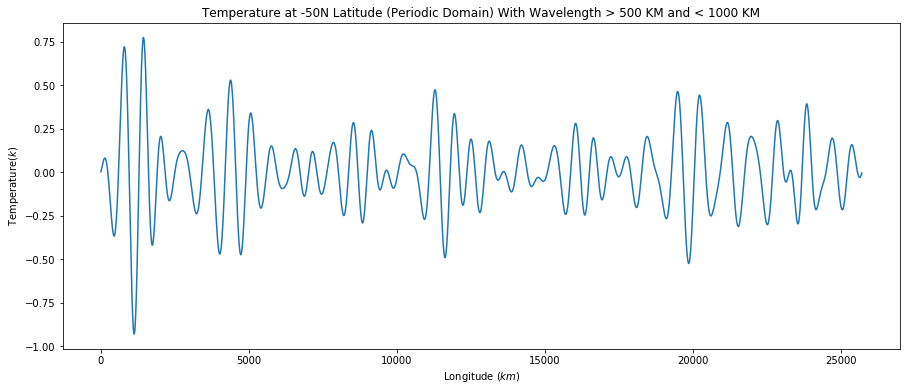

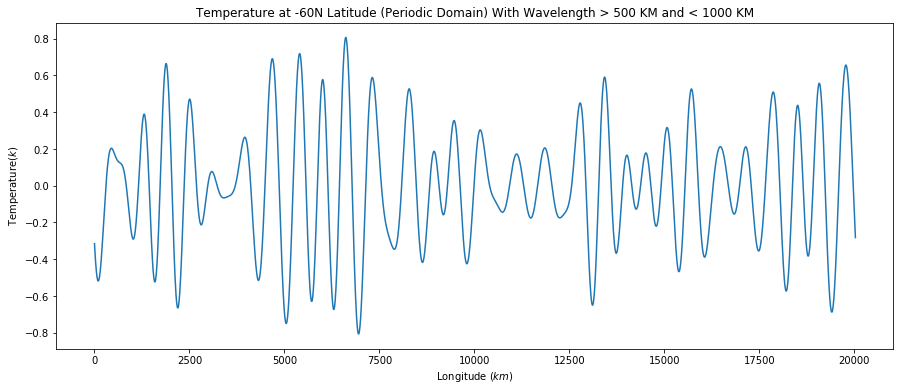

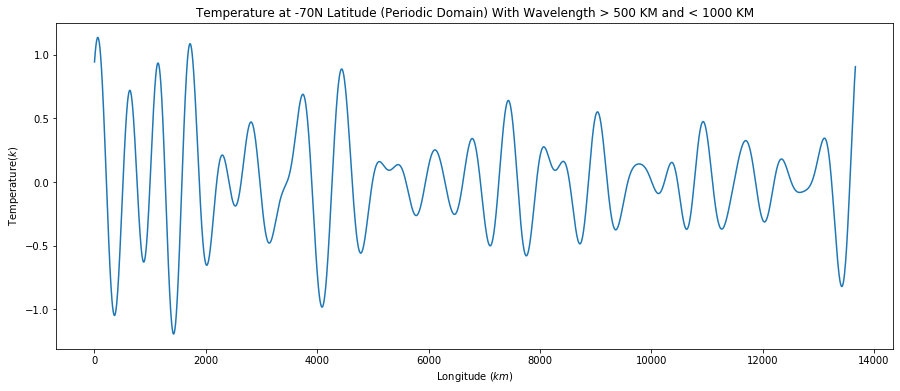

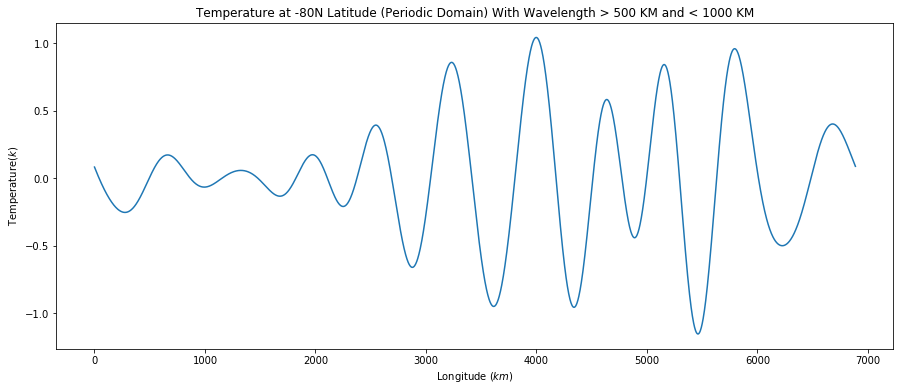

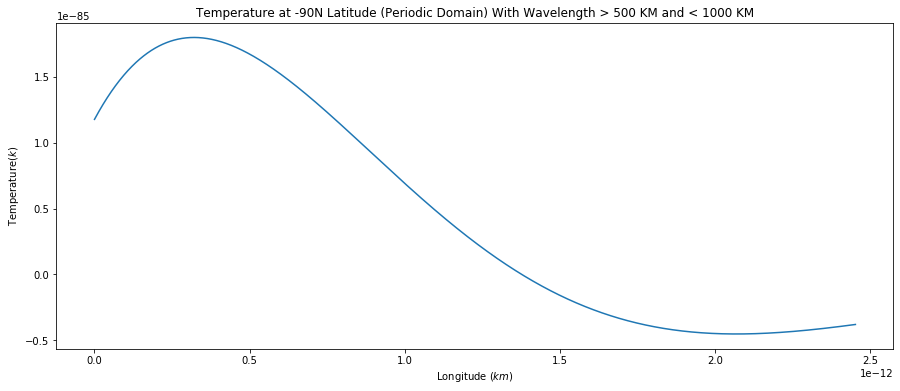

In [34]:
# Run np.fft.ifft and plot against longitude, in kilometers. 
inverse_filter(500, 1000)

# 1000 to 1500 KM Wavelength Waves

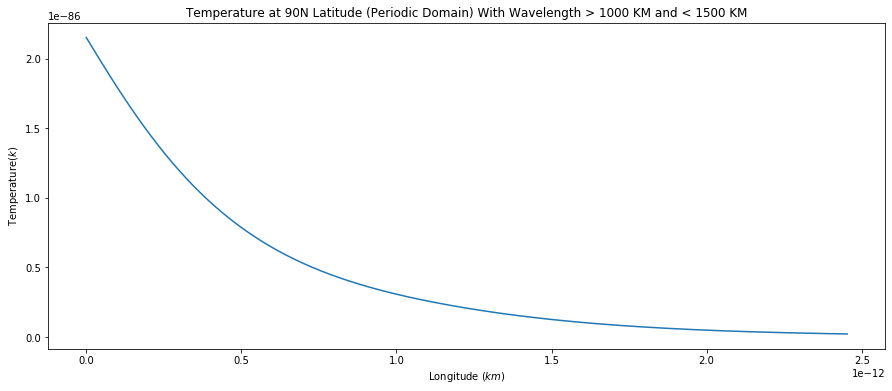

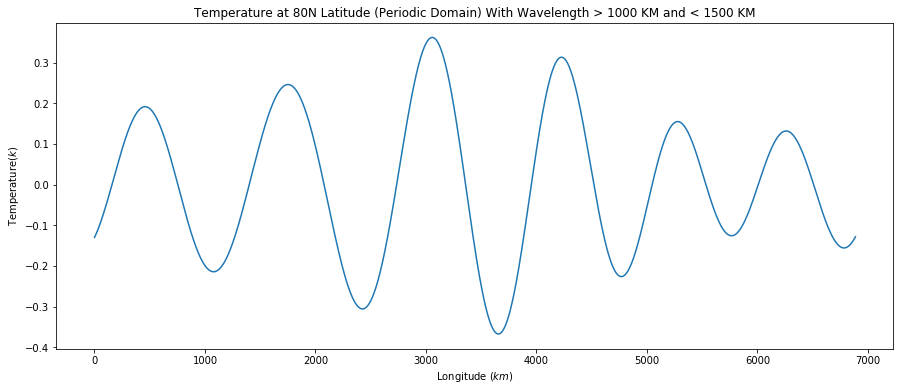

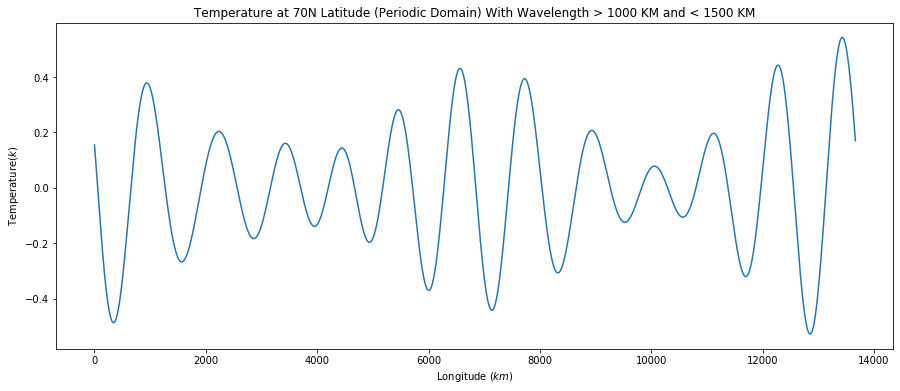

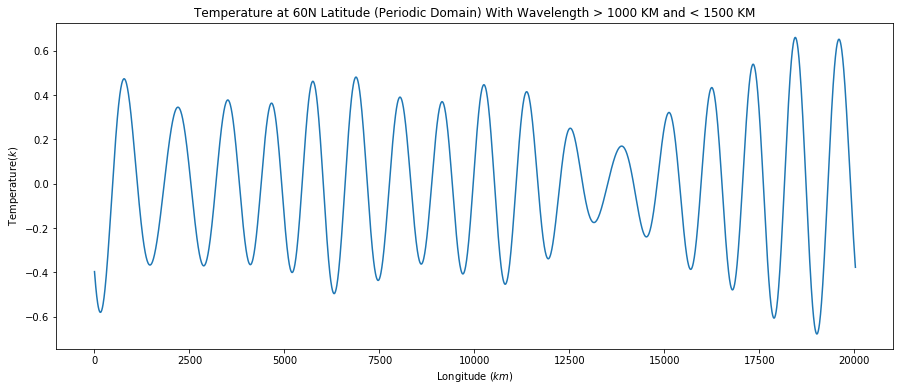

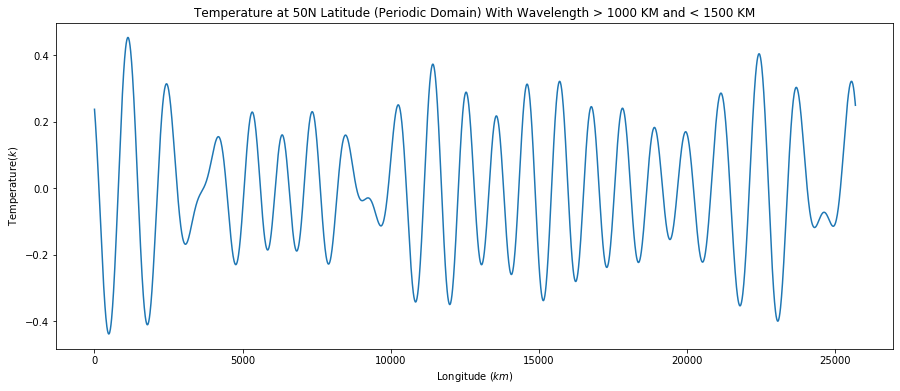

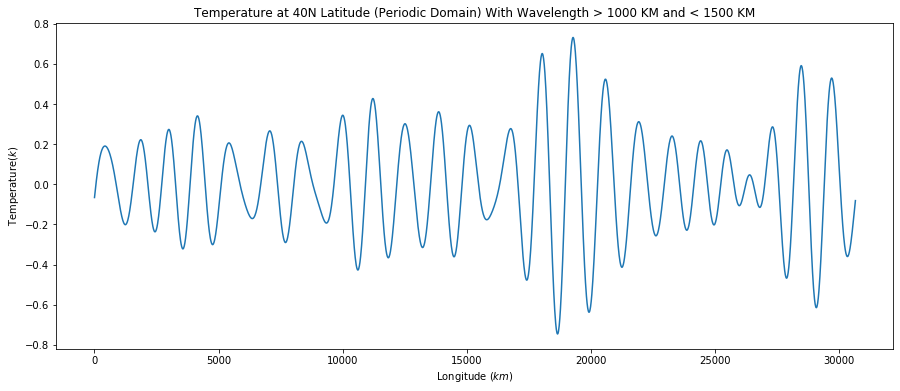

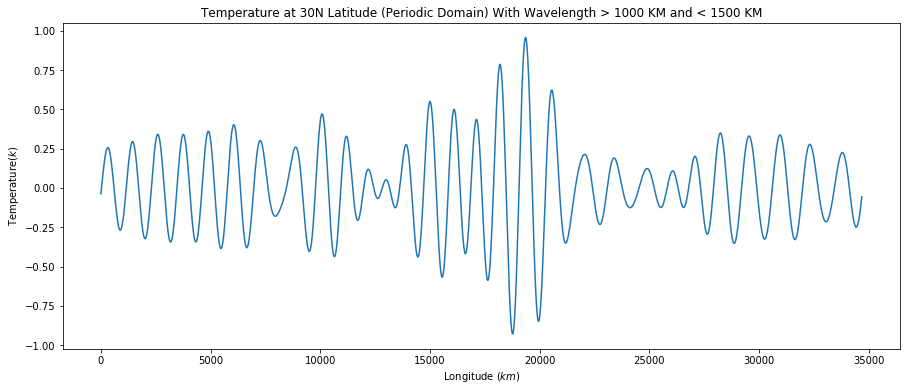

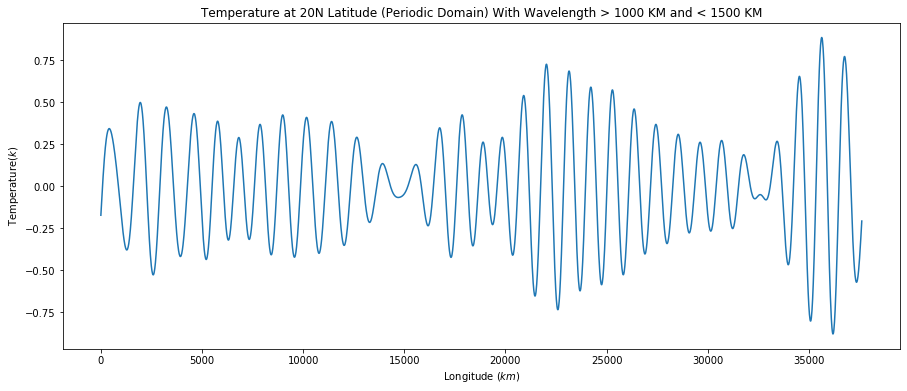

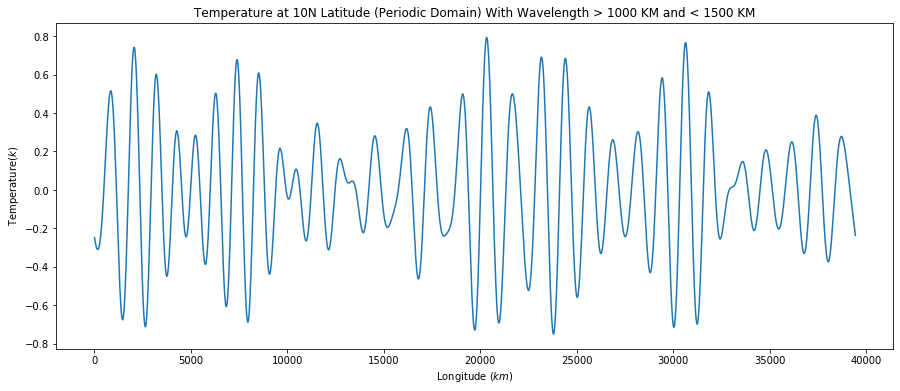

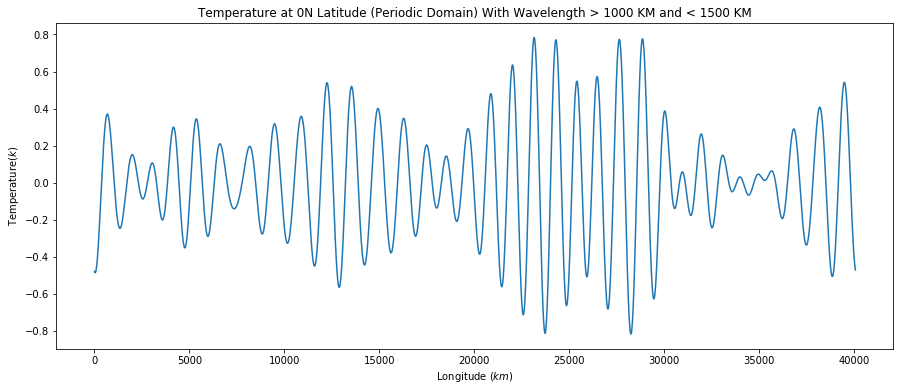

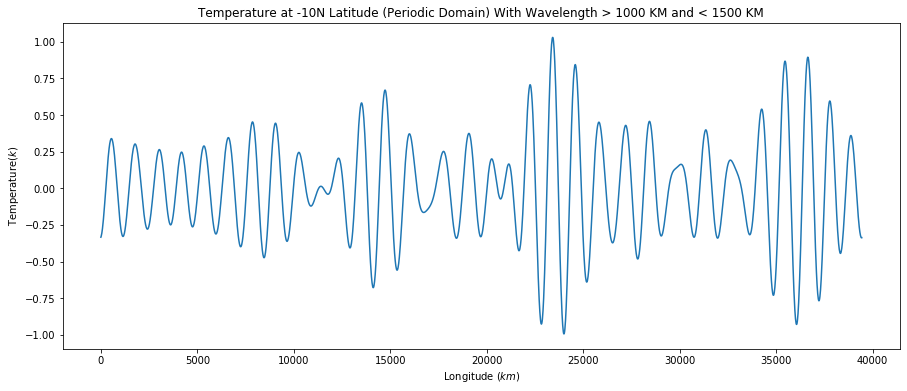

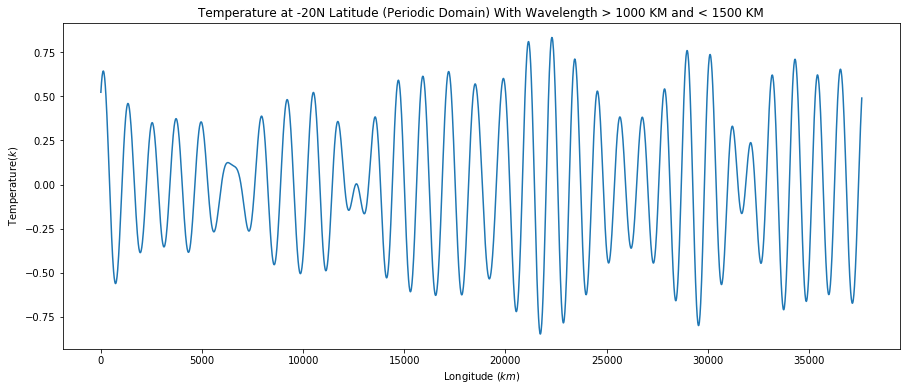

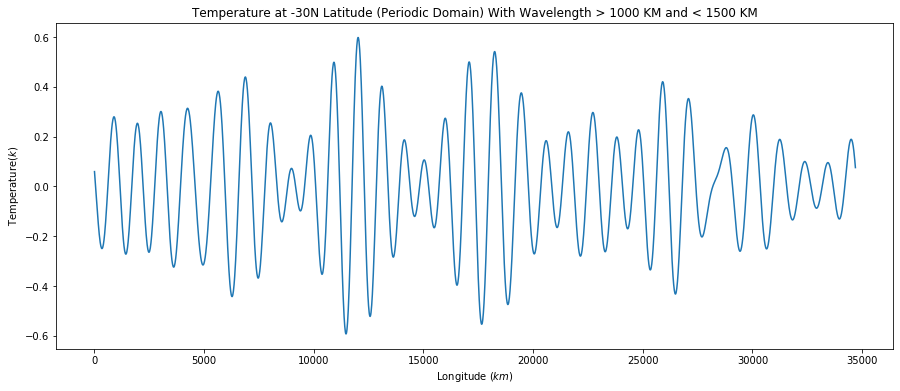

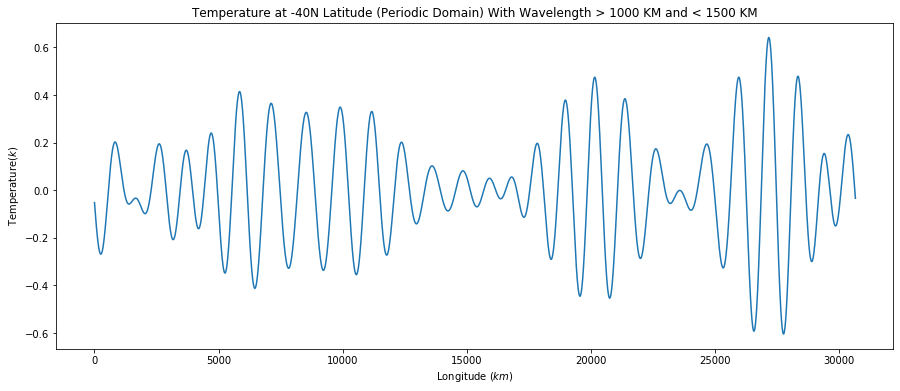

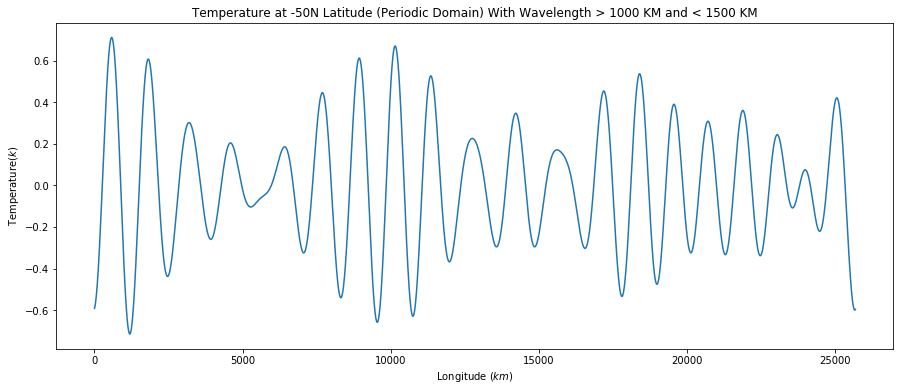

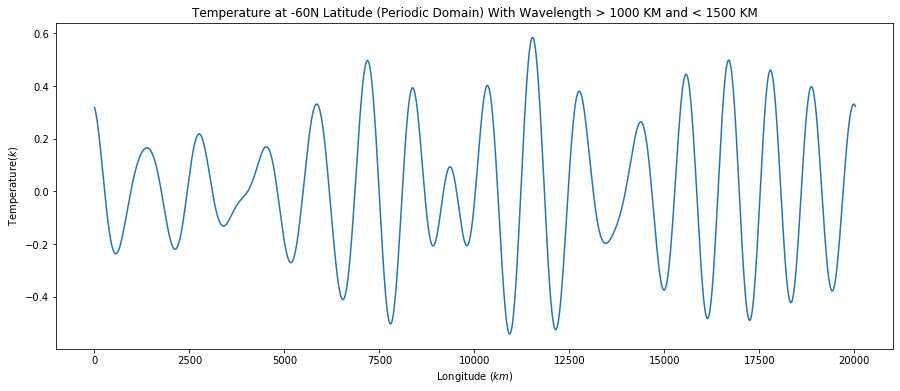

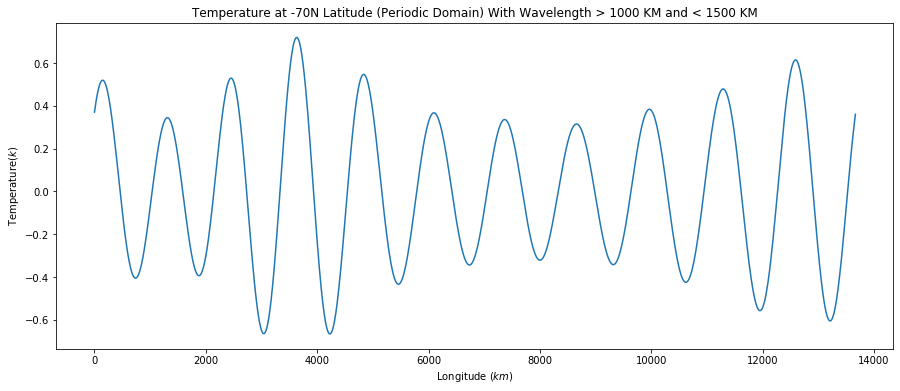

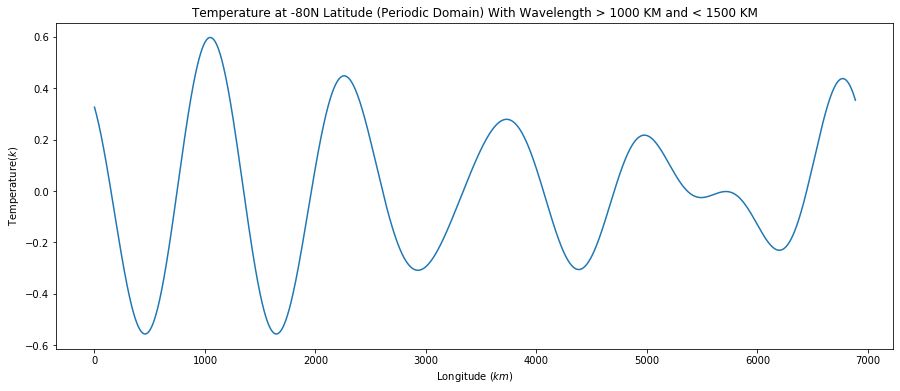

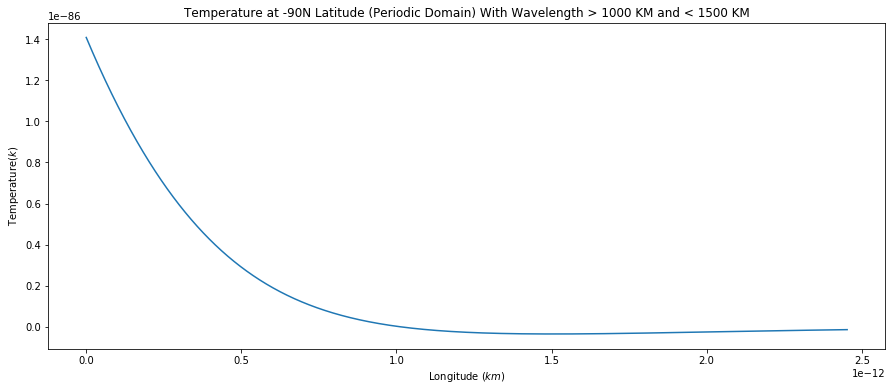

In [35]:
# Run np.fft.ifft and plot against longitude, in kilometers. 

inverse_filter(1000, 1500)

## Perform Sliding Window Function to Gain Average Amplitudes

## Sub-500 Kilometer Waves ## 

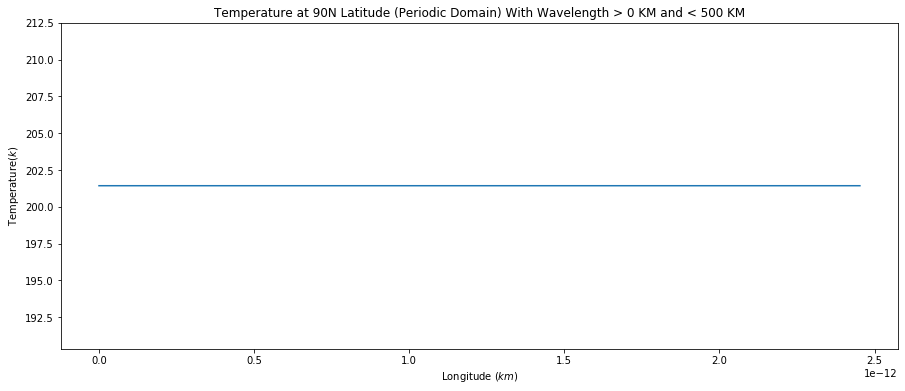

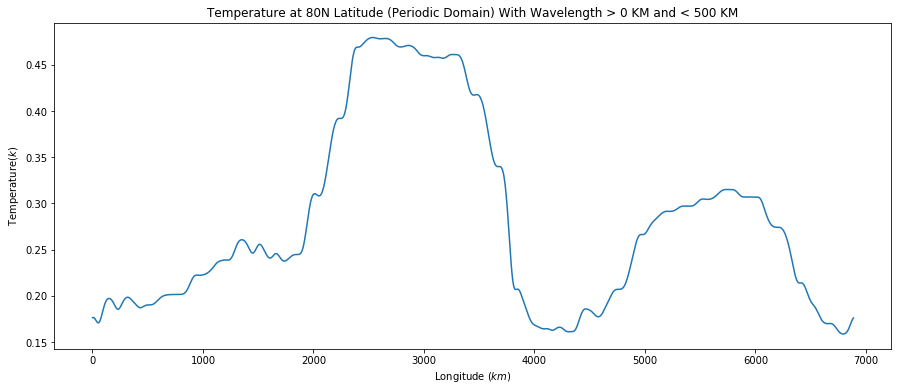

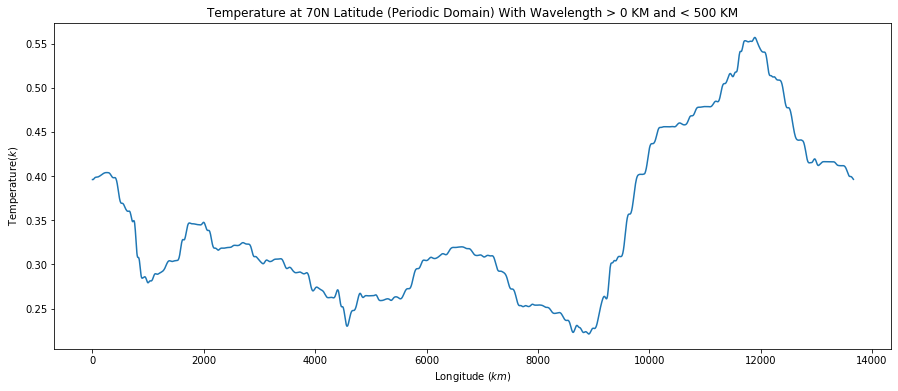

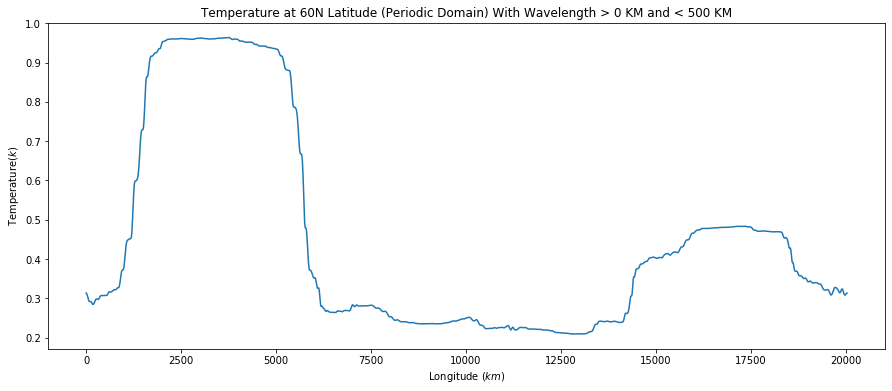

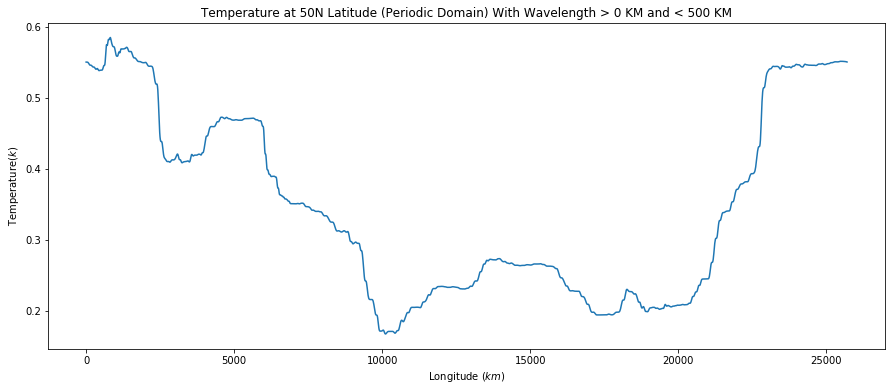

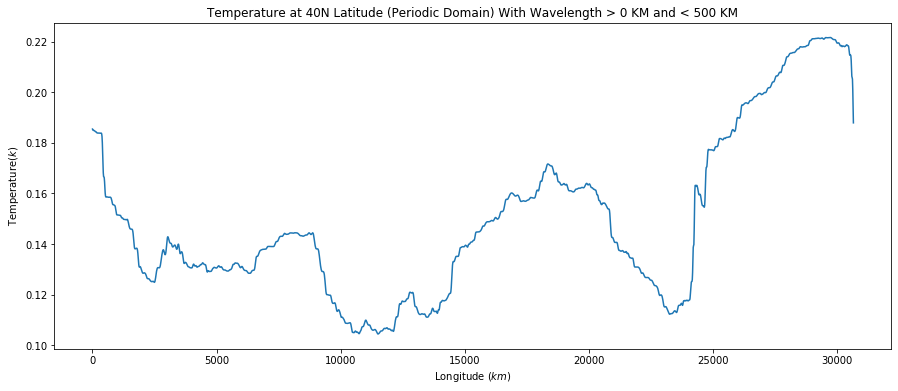

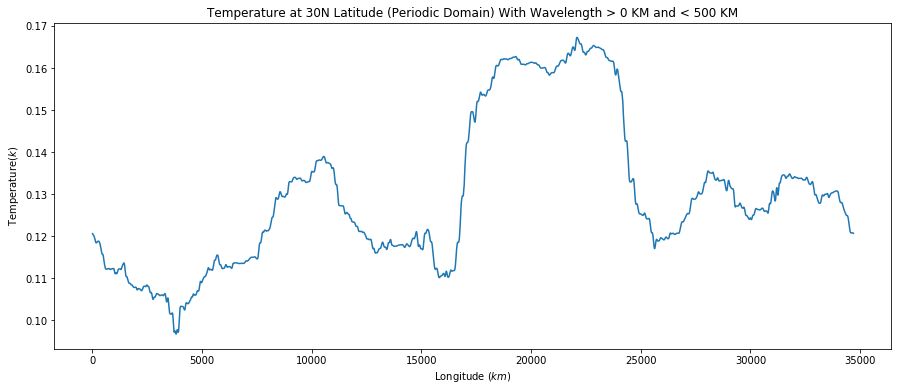

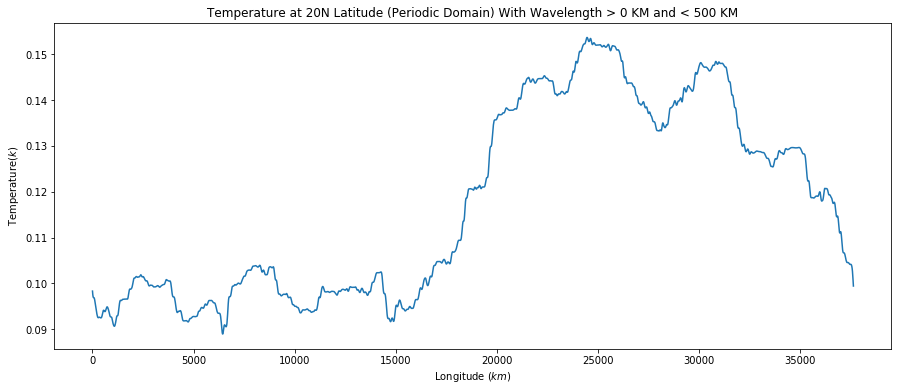

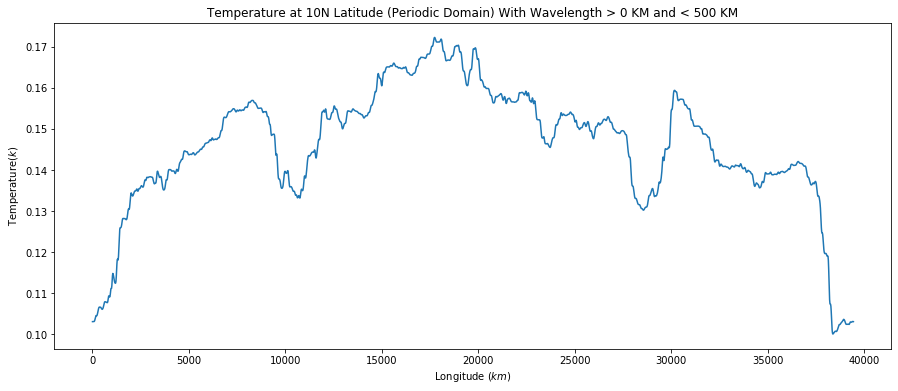

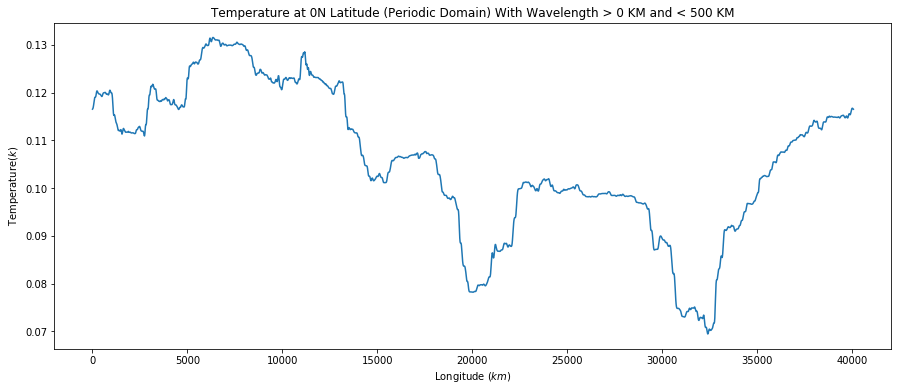

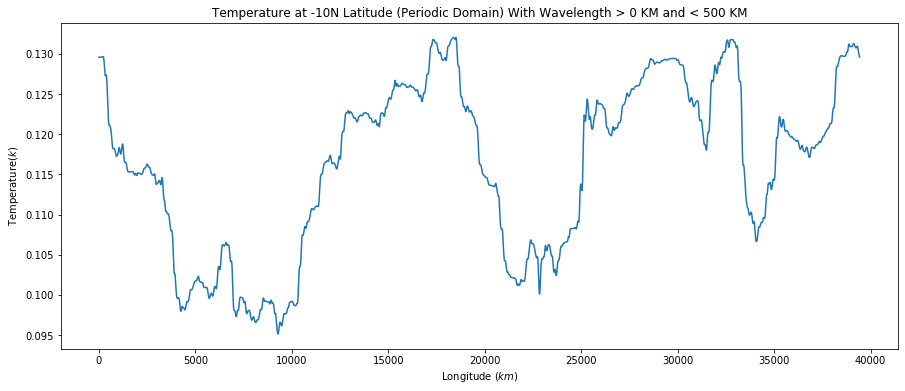

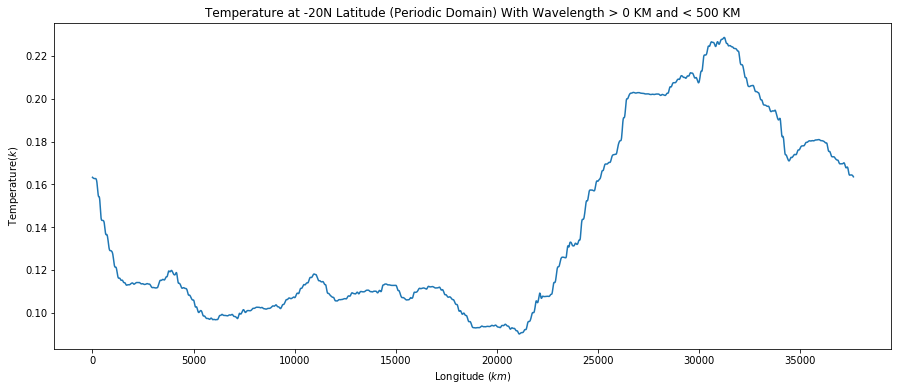

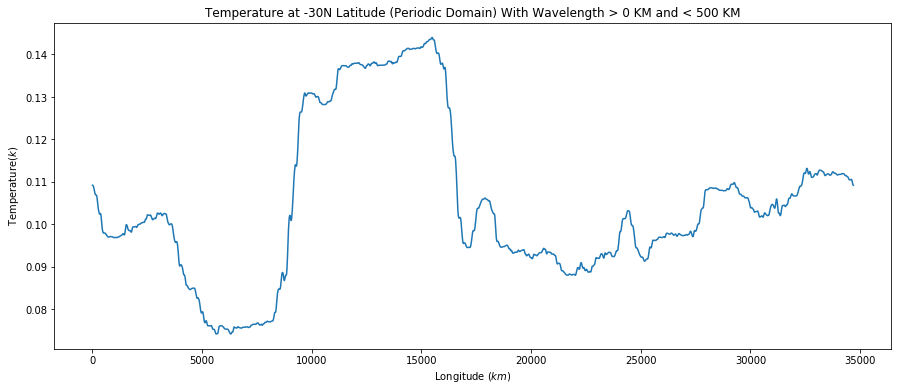

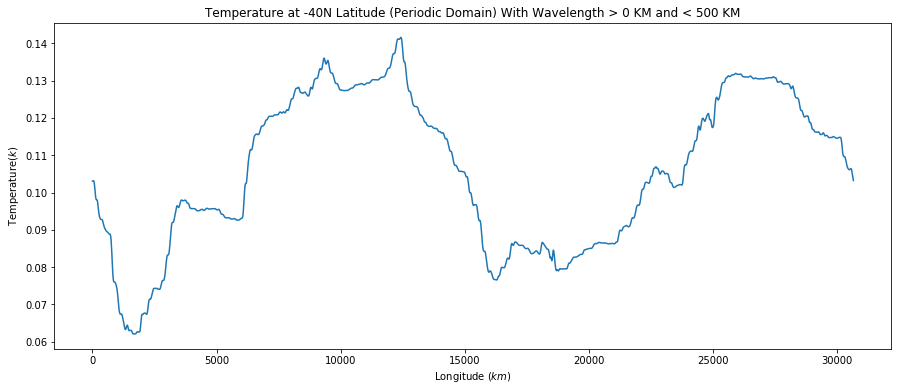

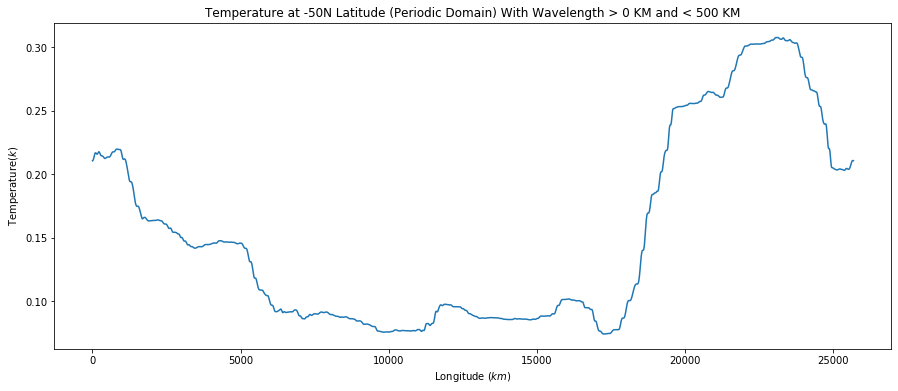

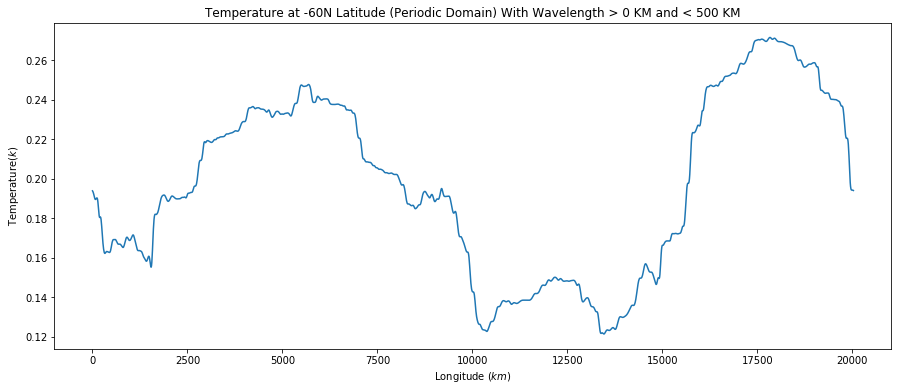

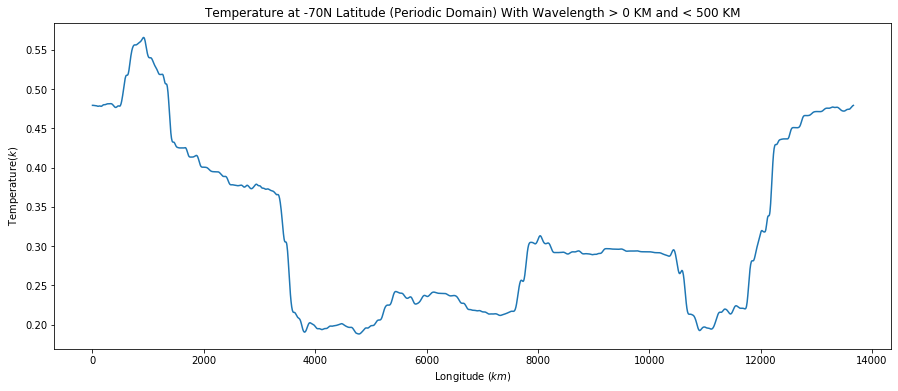

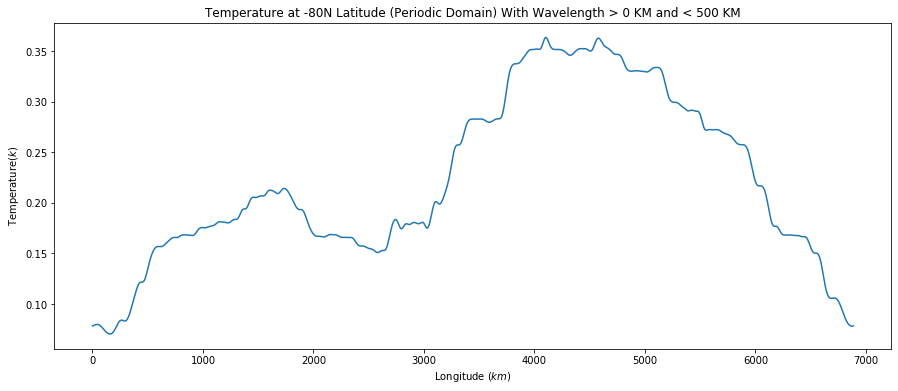

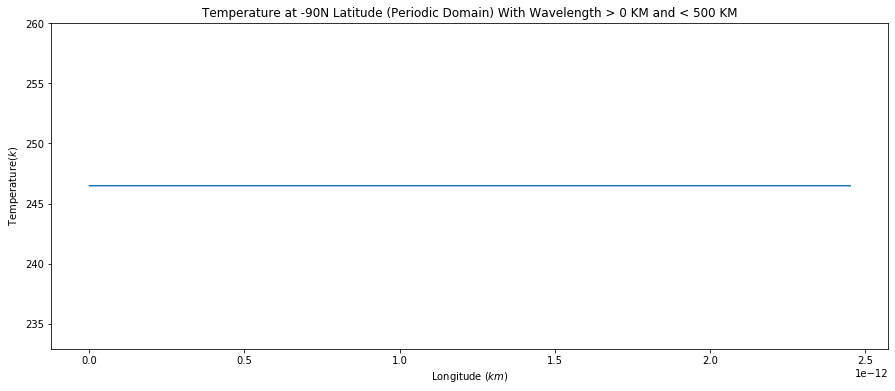

In [36]:
# Plot sliding window amplitudes on map. 

inverse_filter(0, 500, True, 500)
    

## 500 to 1000 KM Wavelength Waves ## 

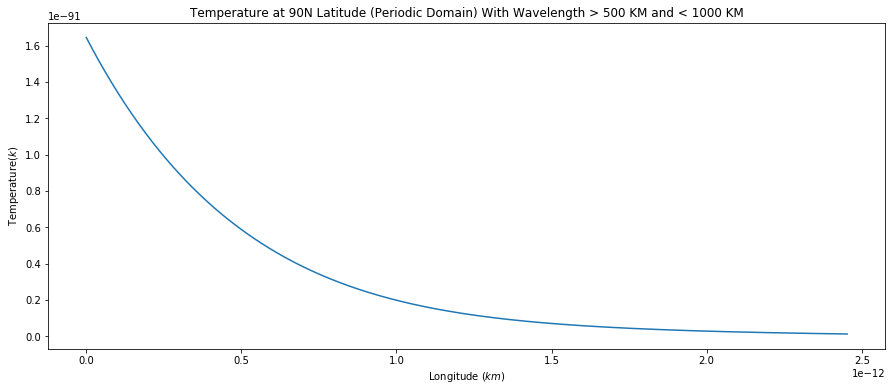

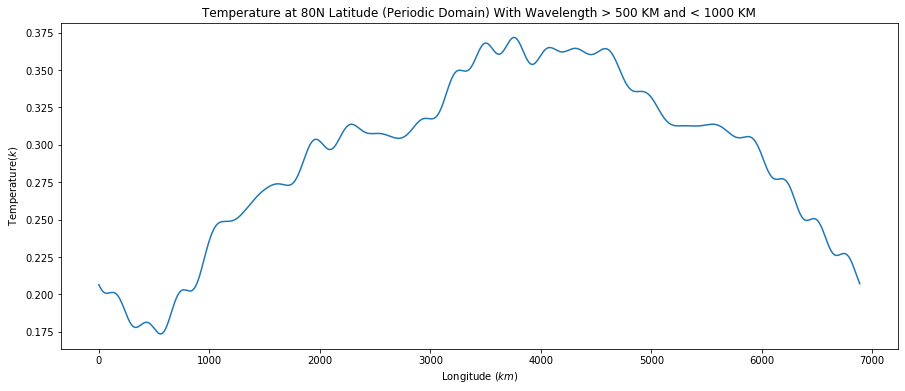

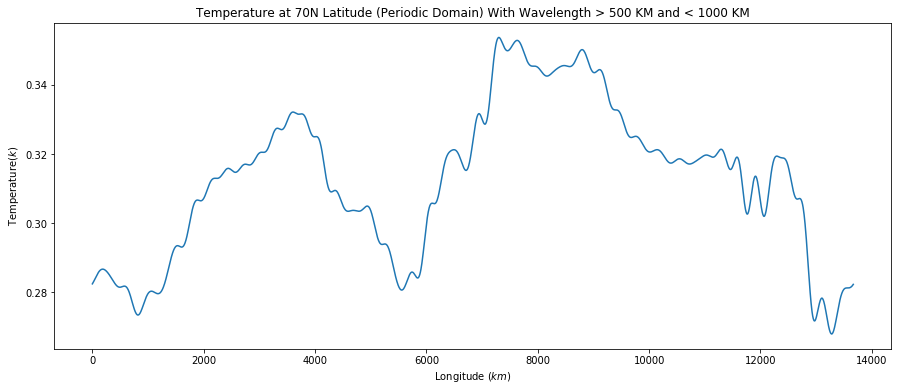

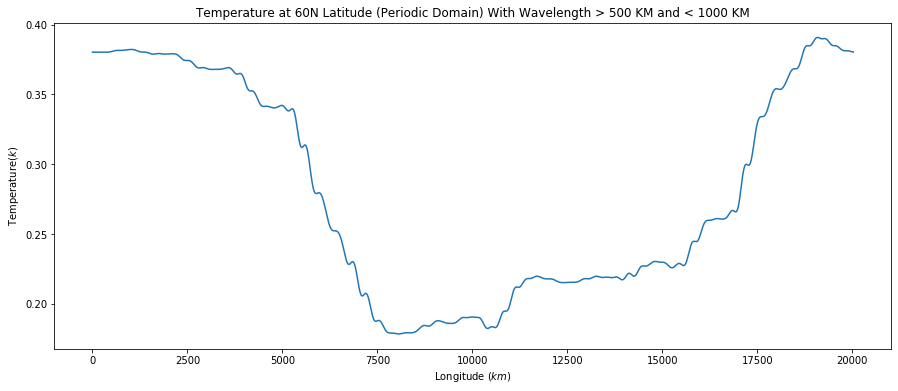

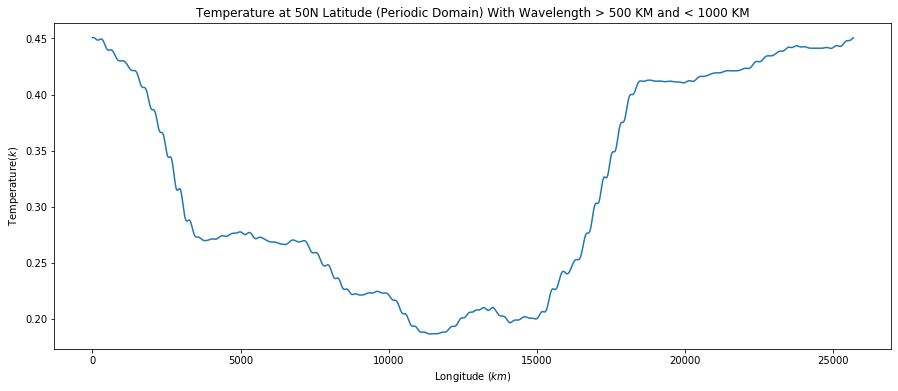

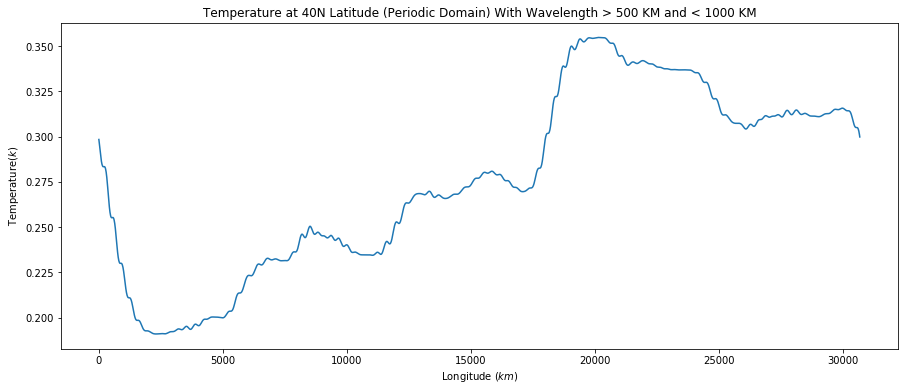

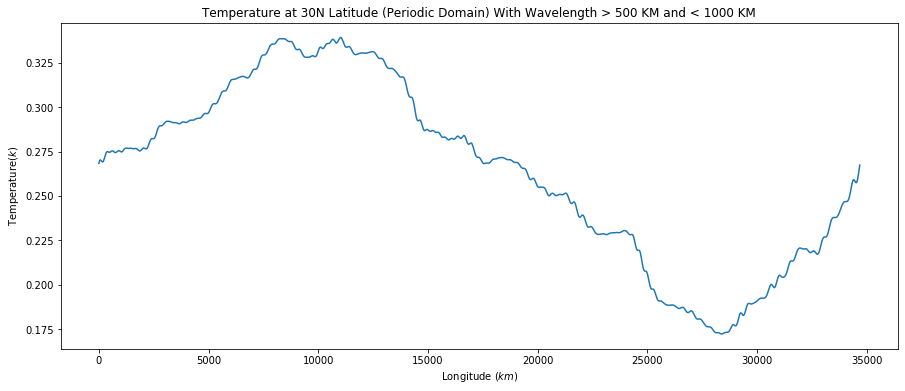

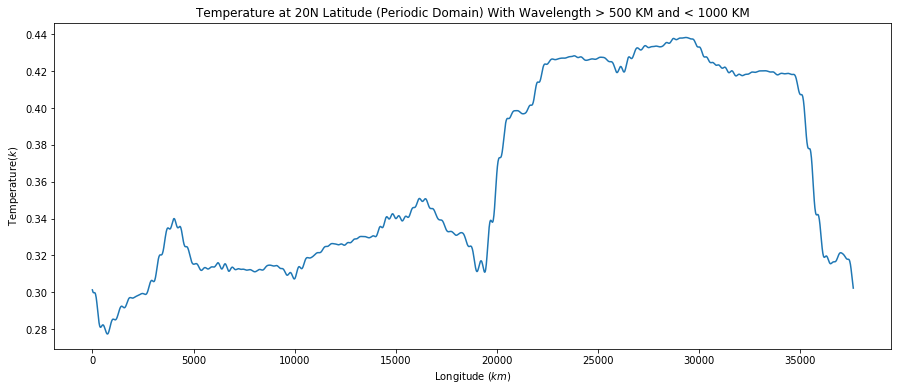

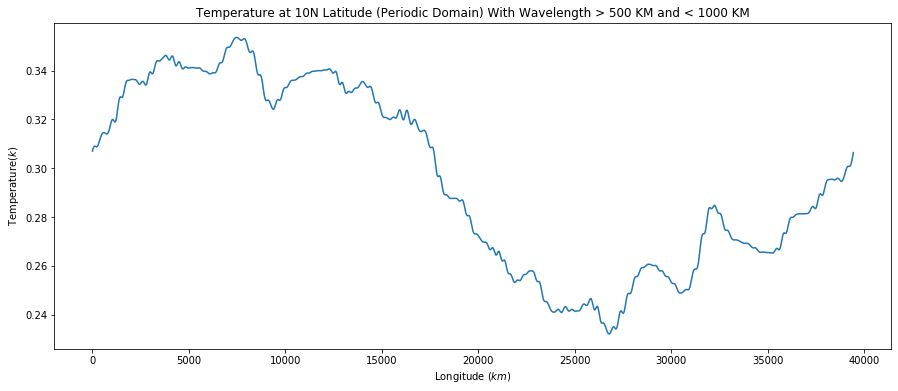

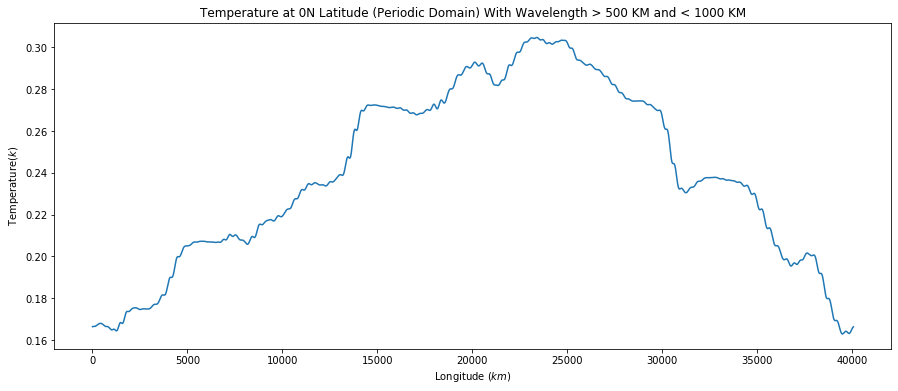

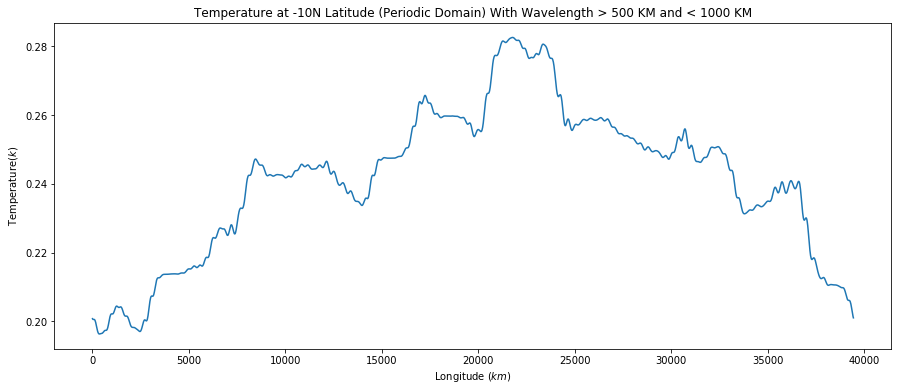

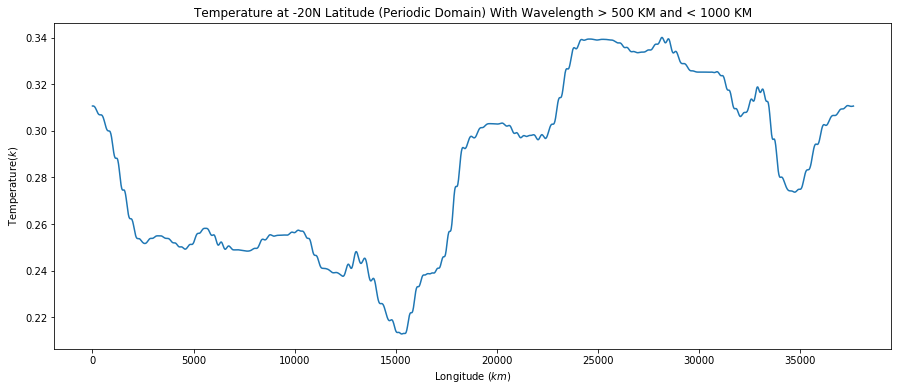

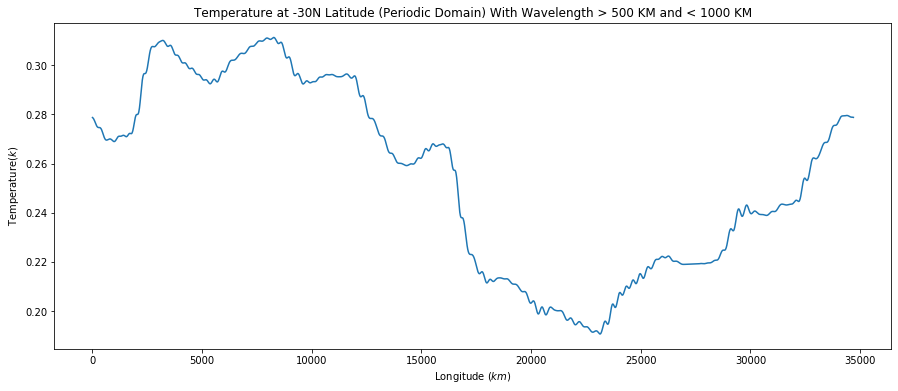

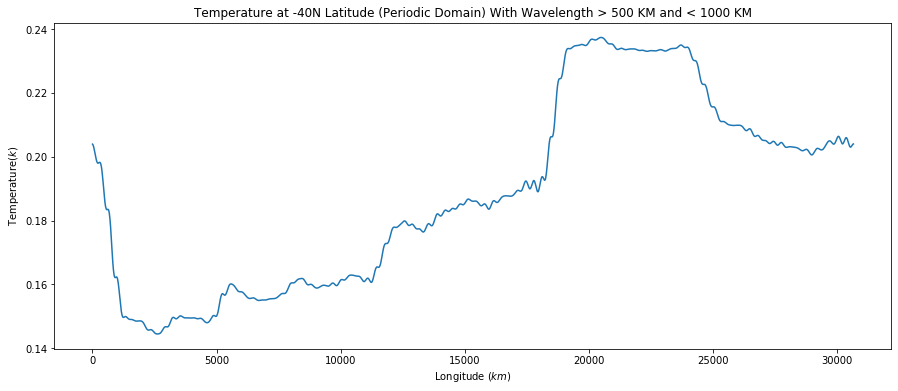

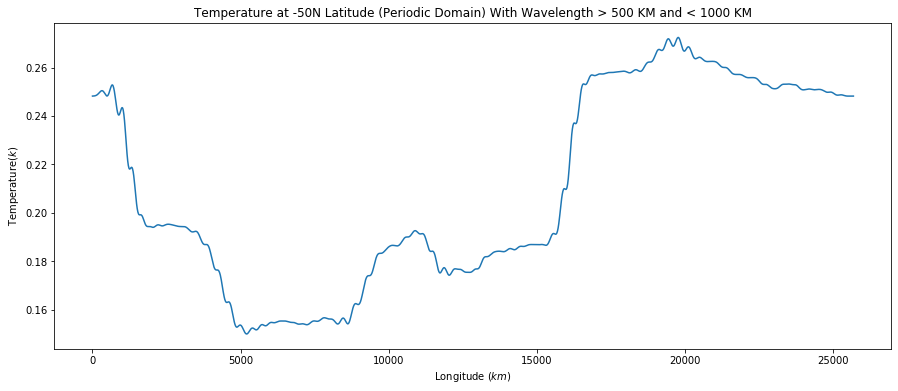

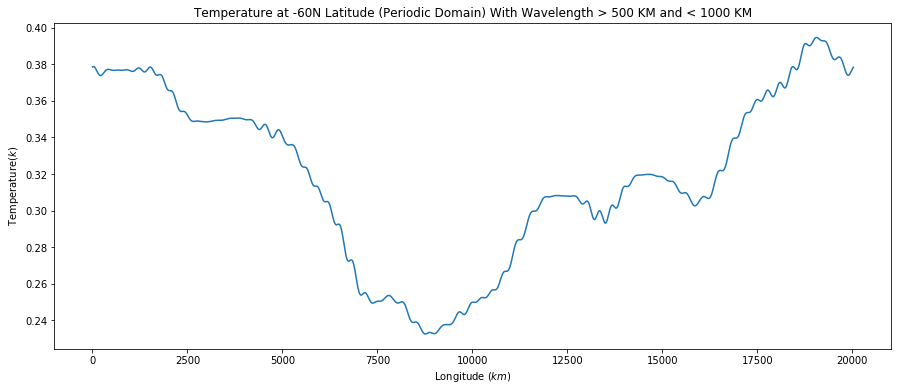

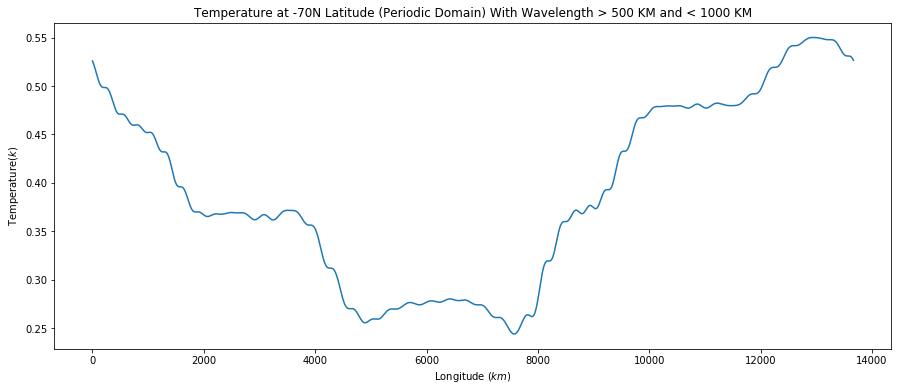

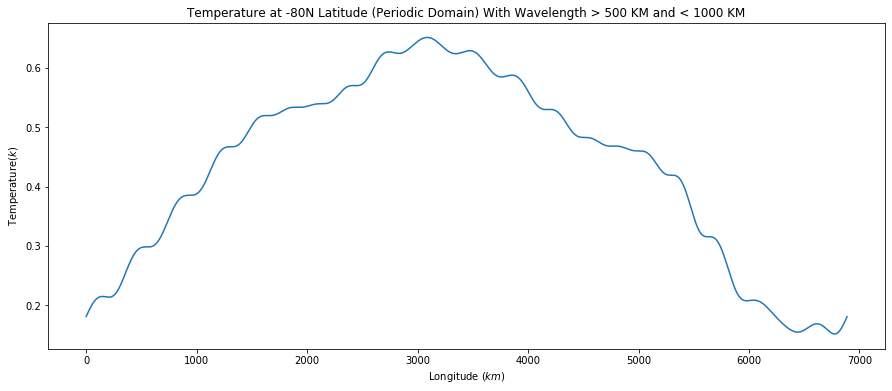

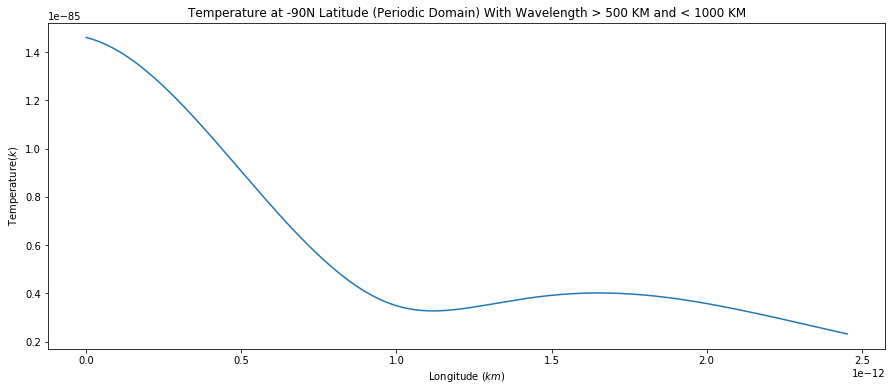

In [37]:
inverse_filter(500, 1000, True, 1000)

## 1000 KM to 1500 KM Wavelength Waves

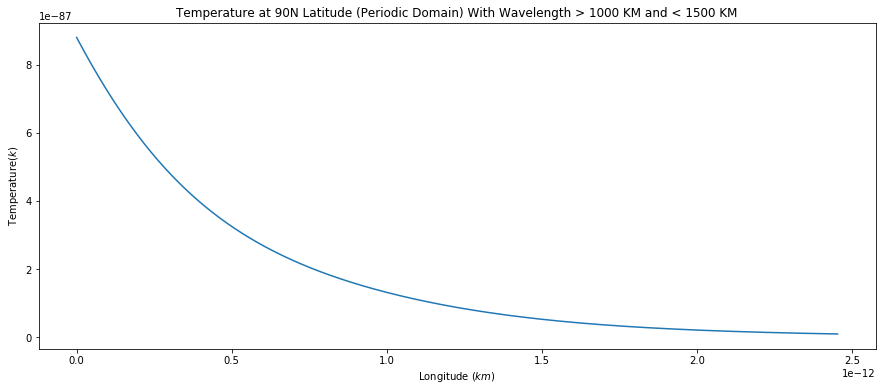

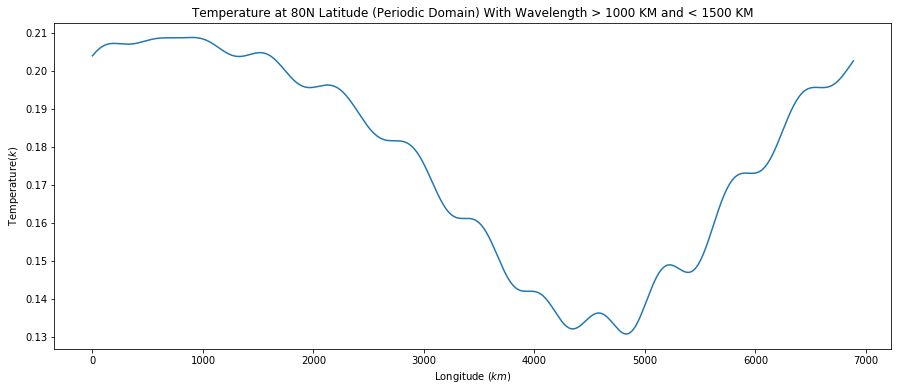

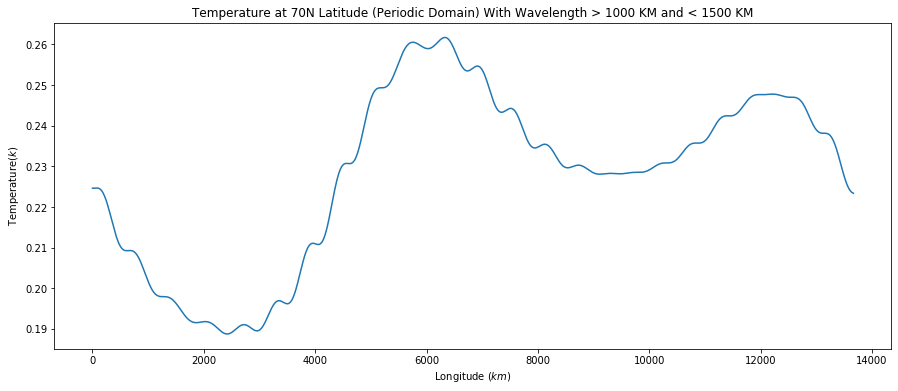

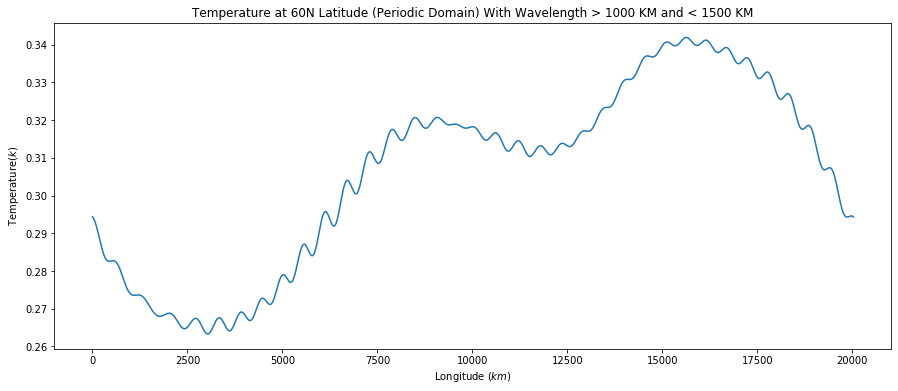

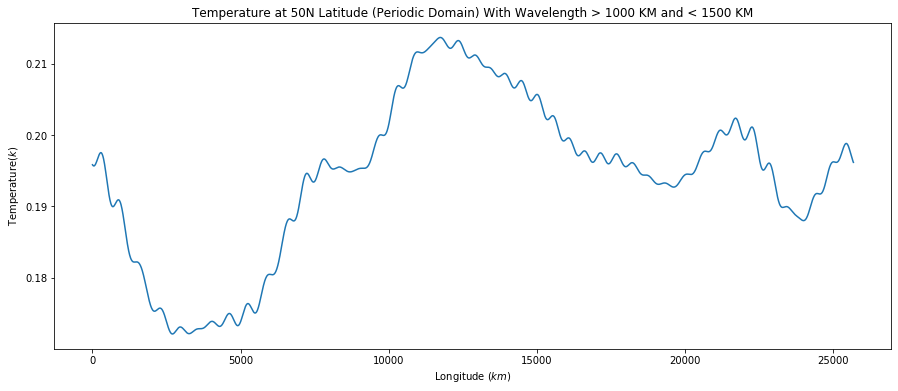

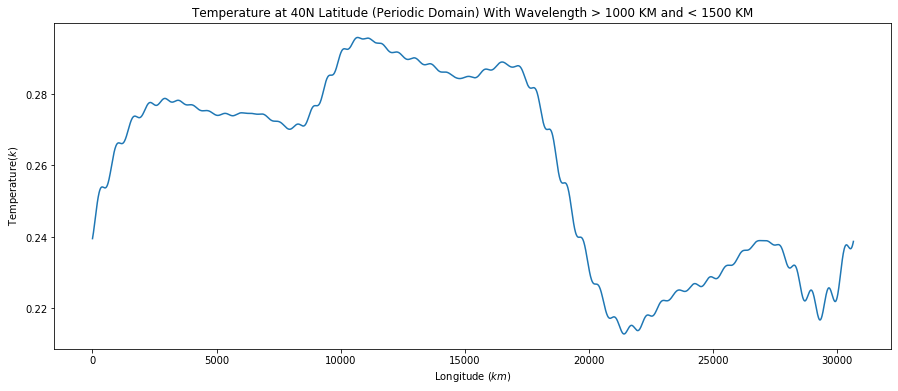

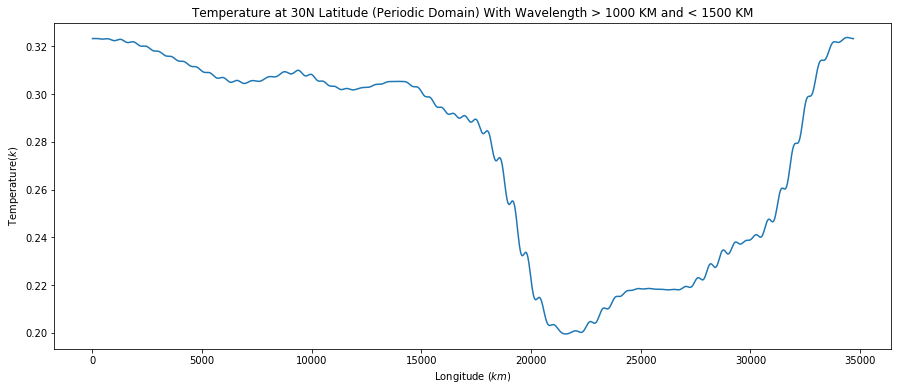

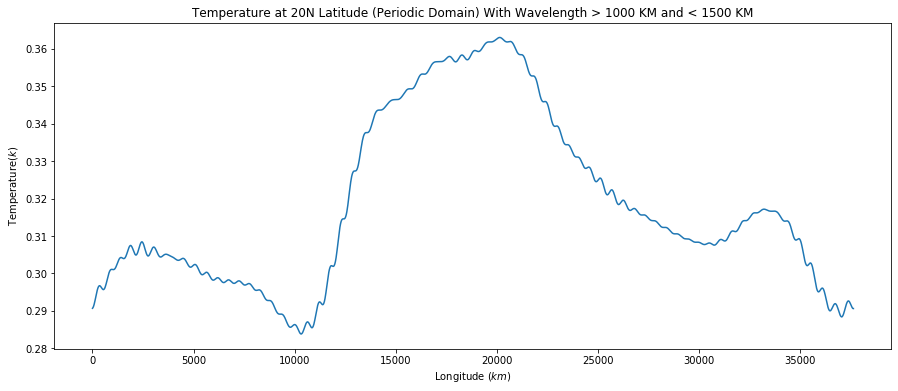

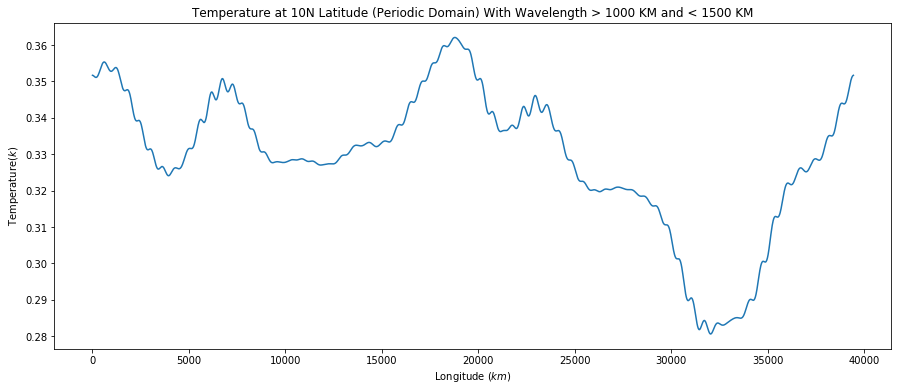

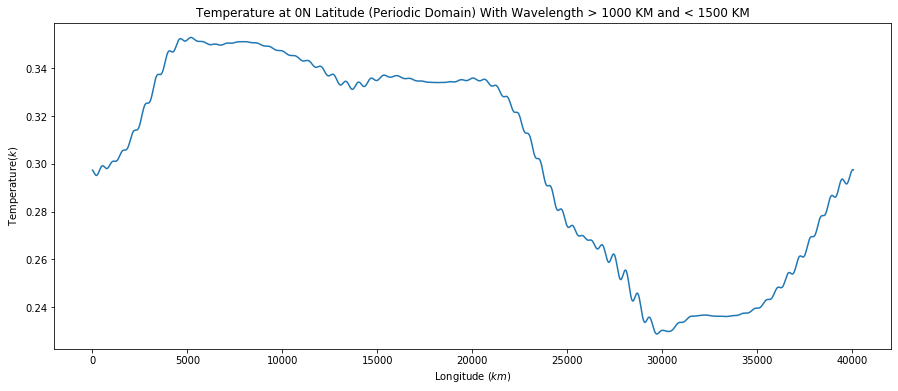

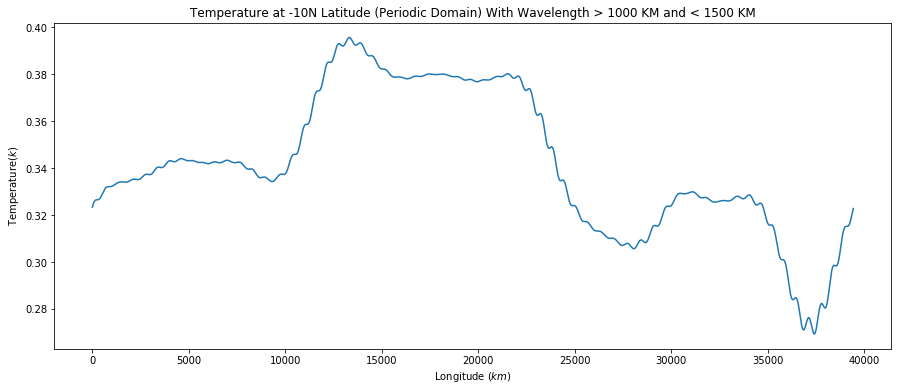

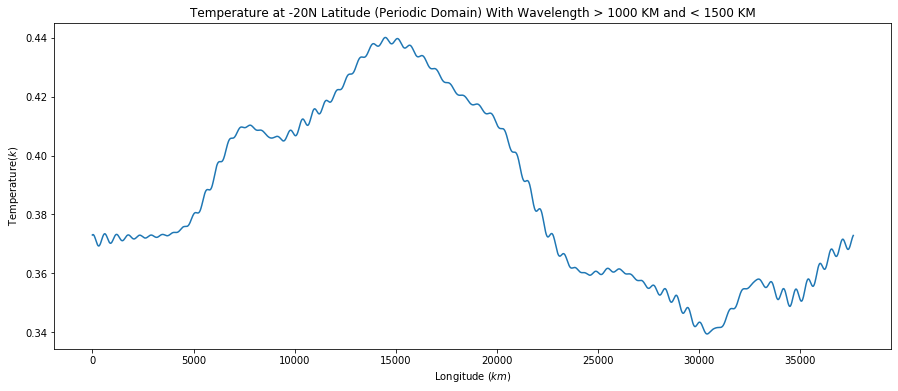

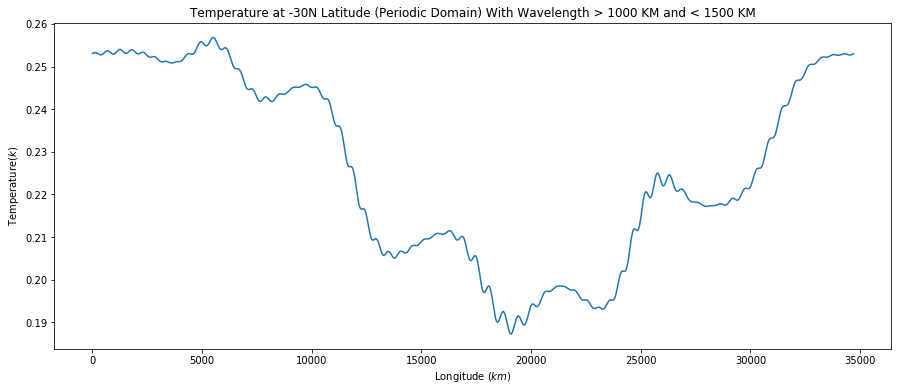

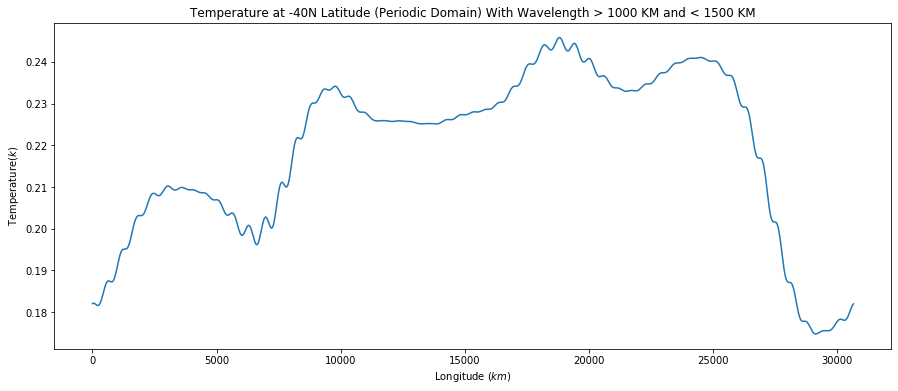

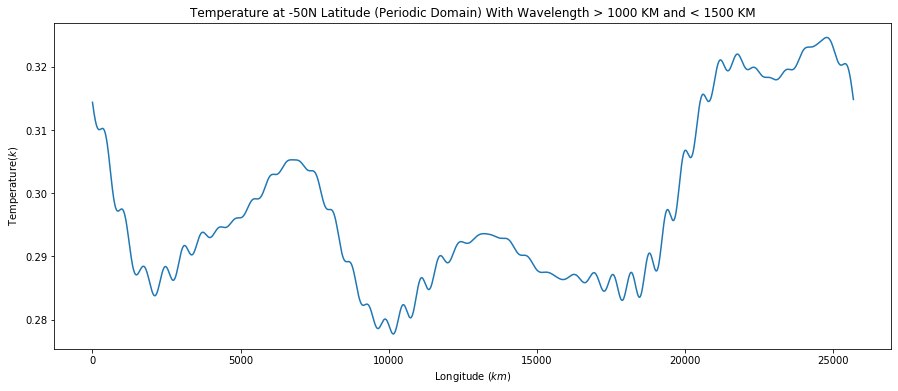

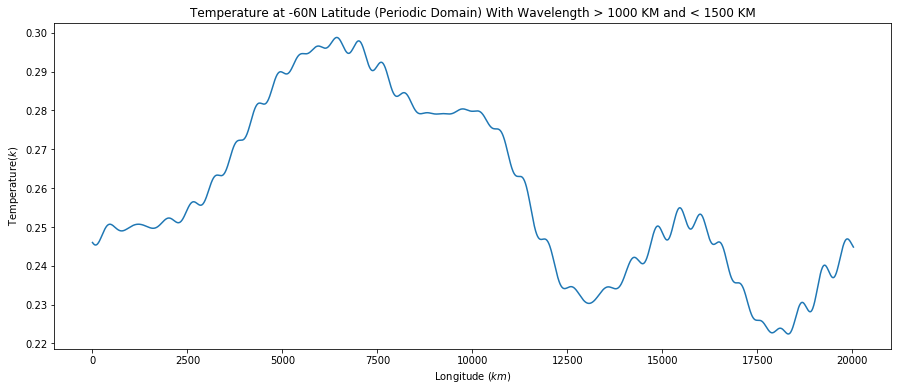

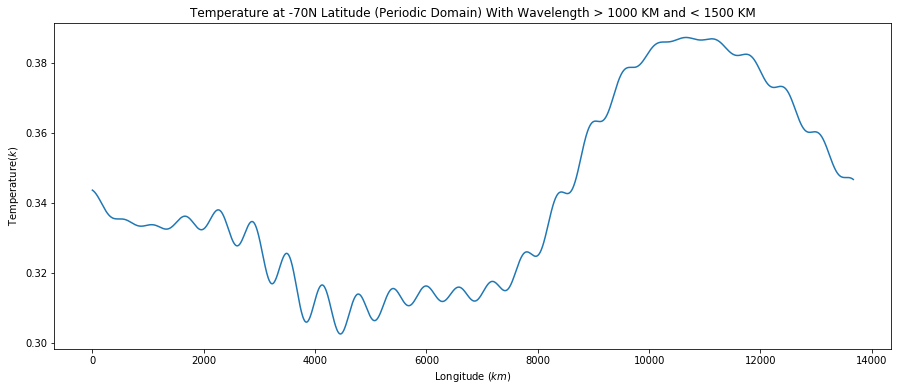

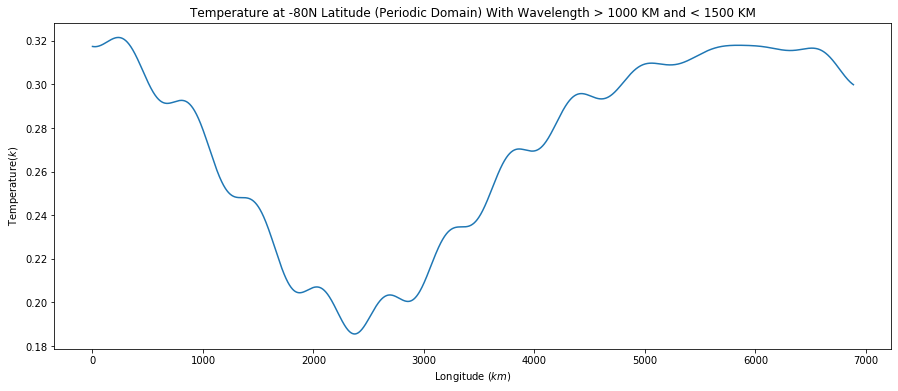

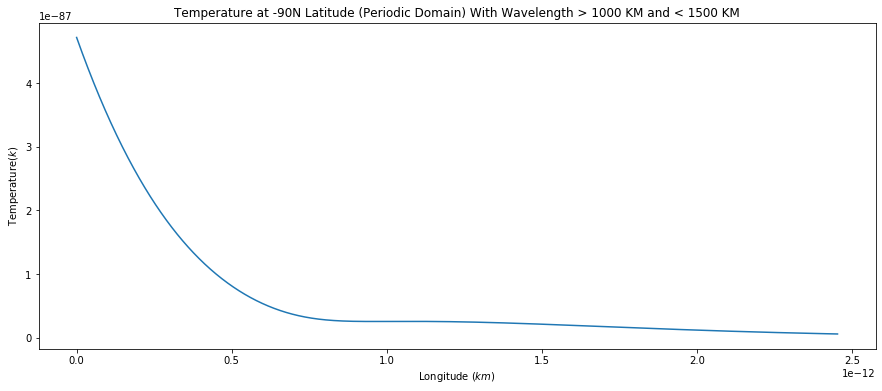

In [38]:
inverse_filter(1000, 1500, True, 1500)

In [39]:
plot_filter(0, 500, True, 500)

NameError: name 'Basemap' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_filter(500, 1000, True, 1000)

In [ ]:
plot_filter(1000, 1500, True, 1500)